In [1]:
import os
import sys
import time
from datetime import date
from datetime import datetime
import time
import json
import platform

import stoneburner
#//*** Custom Functions:
#//*** mr_clean_text(input_series)
#//*** tokenize_series(input_series)
#//*** remove_stop_words(input_series)

# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
subreddits = ["wallstreetbets", "stocks", "wallstreetbetsOGs", "spacs", "investing", "pennystocks", "stockmarket", "options", "robinhoodpennystocks", "wallstreetbetsnew", "smallstreetbets"]
filepath = "./data/"
filename_suffix = "_comments.csv.zip"
#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
#//*** Input_filename: Comments to Process.
#//*** This will eventually be a list of files
#input_filename  =".\\data\\wallstreetbets_comments.csv.zip"
interval="daily"

#//*** Path to processed files
#output_filename = f"./data/processed_reddit_v4_{interval}.csv.zip"
output_filename = f"./ignore_folder/processed_reddit_v4_{interval}.pkl.zip"

#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
#    output_filename = output_filename.replace("\\","/")
#    stock_ticker_filename = stock_ticker_filename.replace("\\","/")

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

symbols = ["amc"]
f.close()

process_tfidf = False

print(symbols)
#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]



raw_df = pd.DataFrame()

start_time = time.time()

#//*** Load each Subreddit for Aggregation
for subreddit in subreddits:
    #//*** Filepath + subreddit name + csv.zip
    input_filename = filepath+subreddit+filename_suffix

    #//*** Convert Path to Mac formatting if needed
    #if platform.system() == 'Darwin':
    #    input_filename = input_filename.replace("\\","/")
   
    print(f"Reading Compressed CSV: {input_filename}")
    
    #//*** Read Each DataFrame and combine with raw_df
    raw_df = pd.concat([raw_df,pd.read_csv(input_filename,compression='zip' )])

#//*** Reset the index, since multiple indexes have been combined
raw_df.reset_index(drop=True, inplace=True)

print(f"Files Loaded: {round(time.time()-start_time,2)}s")
print(f"Total Records: {len(raw_df)}")
    

['amc']
Reading Compressed CSV: ./data/wallstreetbets_comments.csv.zip
Reading Compressed CSV: ./data/stocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsOGs_comments.csv.zip
Reading Compressed CSV: ./data/spacs_comments.csv.zip
Reading Compressed CSV: ./data/investing_comments.csv.zip
Reading Compressed CSV: ./data/pennystocks_comments.csv.zip
Reading Compressed CSV: ./data/stockmarket_comments.csv.zip
Reading Compressed CSV: ./data/options_comments.csv.zip
Reading Compressed CSV: ./data/robinhoodpennystocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsnew_comments.csv.zip
Reading Compressed CSV: ./data/smallstreetbets_comments.csv.zip
Files Loaded: 56.7s
Total Records: 4432533


In [3]:
raw_df['body'] = raw_df['body'].astype('str')

#//*** Convert UTC to date (not datetime)
#//** Second pass goes from 12-21 to 4-19
try:
    raw_df['created_utc'] = raw_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
except:
    print()
    
#//*** Keep just date and body fields
raw_df = raw_df[['created_utc','body']]
raw_df

created_utc                                               body
0       2012-04-11 09:46:43  This is a fantastic idea! I'll toss mine up in...
1       2012-04-11 10:39:08                                    INTC is on 4/17
2       2012-04-11 11:02:31  straddle, call, straddle, put, put, put, strad...
3       2012-04-11 11:47:11  GMCR falls, GOOG falls *slightly*, GRPN will g...
4       2012-04-11 12:44:33  CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...                     ...                                                ...
4432528 2021-06-30 18:34:33  Jun 30, 9.30pm EST.\n\n  \nI just saw this pos...
4432529 2021-06-30 19:08:36  Good run through. The mill is running and we’r...
4432530 2021-06-30 20:11:10                       Back to normal not there yet
4432531 2021-06-30 20:16:51                                             💎👐🚀🚀🚀🚀
4432532 2021-06-30 20:40:35                                  I'll accept that.

[4432533 rows x 2 columns]

In [4]:
raw_df

created_utc                                               body
0       2012-04-11 09:46:43  This is a fantastic idea! I'll toss mine up in...
1       2012-04-11 10:39:08                                    INTC is on 4/17
2       2012-04-11 11:02:31  straddle, call, straddle, put, put, put, strad...
3       2012-04-11 11:47:11  GMCR falls, GOOG falls *slightly*, GRPN will g...
4       2012-04-11 12:44:33  CROX 4/26\n\nBZH 5/1\n\ni'm expecting both to ...
...                     ...                                                ...
4432528 2021-06-30 18:34:33  Jun 30, 9.30pm EST.\n\n  \nI just saw this pos...
4432529 2021-06-30 19:08:36  Good run through. The mill is running and we’r...
4432530 2021-06-30 20:11:10                       Back to normal not there yet
4432531 2021-06-30 20:16:51                                             💎👐🚀🚀🚀🚀
4432532 2021-06-30 20:40:35                                  I'll accept that.

[4432533 rows x 2 columns]

In [5]:
for symbol in symbols:
    stock_df = pd.read_csv(f"./stocks/{symbol}_{interval}.csv.zip")
    stock_df
    
    if 'date' in stock_df.columns:
        stock_df['date'] = pd.to_datetime(stock_df['date'])
        stock_df = stock_df.rename(columns={'date':'time'})
    else:
        stock_df['time'] = pd.to_datetime(stock_df['time'])
    
    #//*** Keeping this cool chunk of code as a reference
    #stock_df['time'] = stock_df['time'].apply(lambda x: x.timestamp())
    
    #//*** Remove Comments older than the first stock price
    raw_df = raw_df[ raw_df['created_utc'] >= stock_df['time'].min() ]
    
    #//*** Remove Stock Prices older than the first Comments price
    stock_df = stock_df[ stock_df['time'] >= raw_df['created_utc'].min() ]
    
    #//*** Remove Stock Prices older than the last Comments
    stock_df = stock_df[ stock_df['time'] <= raw_df['created_utc'].max() ]
    
    #//*** Reorder Comments by date
    raw_df.sort_values('created_utc',inplace=True,ignore_index=True)
    
    #//*** Reorder Stocks by date
    stock_df.sort_values('time',inplace=True, ignore_index=True)
stock_df

<ipython-input-5-9596dbd0137d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df.sort_values('created_utc',inplace=True,ignore_index=True)


time symbol   open   high    low  close    volume
0    2014-04-11    amc  22.73  23.71  21.91  23.60    581500
1    2014-04-14    amc  23.88  24.01  23.51  23.59    305200
2    2014-04-15    amc  23.66  23.94  22.17  22.41    264700
3    2014-04-16    amc  22.45  22.63  22.02  22.51    191000
4    2014-04-17    amc  22.44  22.65  21.68  22.30    367100
...         ...    ...    ...    ...    ...    ...       ...
1813 2021-06-24    amc  57.98  58.76  55.66  56.70  80351219
1814 2021-06-25    amc  55.75  56.29  52.97  54.06  77596927
1815 2021-06-28    amc  55.10  59.36  54.33  58.11  99310240
1816 2021-06-29    amc  59.06  61.00  56.18  56.43  63604135
1817 2021-06-30    amc  56.00  58.18  54.65  56.68  59020626

[1818 rows x 7 columns]

In [6]:
stock_df

time symbol   open   high    low  close    volume
0    2014-04-11    amc  22.73  23.71  21.91  23.60    581500
1    2014-04-14    amc  23.88  24.01  23.51  23.59    305200
2    2014-04-15    amc  23.66  23.94  22.17  22.41    264700
3    2014-04-16    amc  22.45  22.63  22.02  22.51    191000
4    2014-04-17    amc  22.44  22.65  21.68  22.30    367100
...         ...    ...    ...    ...    ...    ...       ...
1813 2021-06-24    amc  57.98  58.76  55.66  56.70  80351219
1814 2021-06-25    amc  55.75  56.29  52.97  54.06  77596927
1815 2021-06-28    amc  55.10  59.36  54.33  58.11  99310240
1816 2021-06-29    amc  59.06  61.00  56.18  56.43  63604135
1817 2021-06-30    amc  56.00  58.18  54.65  56.68  59020626

[1818 rows x 7 columns]

In [7]:
#//*** Group the stock values by time, this is essentially like itterrows()
groups = stock_df.groupby('time')


In [28]:
cdf = raw_df.copy()

#https://www.geeksforgeeks.org/how-to-iterate-over-dataframe-groups-in-python-pandas/
key_list = list(groups.groups.keys())

bin_df = pd.DataFrame()

start_time = time.time()
comment_min_time = raw_df['created_utc'].min()
comment_max_time = raw_df['created_utc'].max()
min_index = 0
start_time = time.time()
print("Processing...")
for x in range(len(key_list)-1):
    
    #//*** Get a single line of stocks as a dataframe
    loop_stocks_df = groups.get_group((key_list)[x]).copy()  
    
    t1 = groups.get_group((key_list)[x])['time'].iloc[0]
    t2 = groups.get_group((key_list)[x+1])['time'].iloc[0]
    
    #search through cdf to find comments that are between t1 and t2
    #if len(cdf[ (cdf['created_utc'] > t1) & (cdf['created_utc'] < t2) ]) > 0:
    #temp_df = cdf.iloc[min_index:]
    temp_df = cdf[(cdf['created_utc'] >= t1) & (cdf['created_utc'] < t2) ]
    
    if len(temp_df) == 0:
            #//*** No COmments on this Date
            loop_stocks_df['body'] = " "
            loop_stocks_df['comment_count'] = 0
    else:
        #print(temp_df.index[0])
        #print(temp_df.index[-1])
        #print(cdf.iloc[temp_df.index[0]:temp_df.index[-1]])
        temp_df = cdf.iloc[temp_df.index[0]:temp_df.index[-1]]
        #//*** Get all the body comments and combine them
        loop_stocks_df['body'] = " ".join(list(temp_df['body']))

        #//*** Get a comment count, BC IDK Y
        loop_stocks_df['comment_count'] = len(temp_df['body']) 
    
    #//*** Secret to speeding up algorithm. Get the Index value of the last item found -1. 
    #//*** When Searching above, start the search from this index. Seems to speed things up. Since we're skipping past elements that we've already found
    if len(temp_df) > 0: 
        min_index = temp_df.index[-1]

        
    
    #//*** Add the single line of loop_stocks_df to bin_df    
    bin_df = pd.concat([bin_df,loop_stocks_df])
        #print(loop_df.index)
        #print(loop_df)
        #cdf = cdf.drop(index=loop_df.index)
    
        
    
    #lengroup
   
    #if x > 1000:
    #    bin_df.head(20)
    #    print("break")
    #    break
print(f"Elapsed {round(time.time()-start_time,2)}")

#print("Merging")
#bin_df = pd.merge(bin_df,stock_df,left_on='bin_time',right_on='time')

#del bin_df['bin_time']
#print(bin_df)
print("Pickling")

#bin_df.to_pickle(output_filename,compression='zip')
print("Done!")

Processing...
Elapsed 77.16
Pickling
Done!


In [59]:
tdf = bin_df[bin_df['time'] >= pd.to_datetime("2020-01-01")]
tdf



time symbol   open   high     low  close     volume  \
1441 2020-01-02    amc   7.30   7.56   7.230   7.46    4545935   
1442 2020-01-03    amc   7.45   7.60   7.305   7.32    2217959   
1443 2020-01-06    amc   7.25   7.30   7.110   7.12    2903381   
1444 2020-01-07    amc   7.11   7.20   7.000   7.13    3206587   
1445 2020-01-08    amc   7.11   7.15   6.610   6.62    6556979   
...         ...    ...    ...    ...     ...    ...        ...   
1812 2021-06-23    amc  57.04  61.10  56.800  58.30  116291804   
1813 2021-06-24    amc  57.98  58.76  55.660  56.70   80351219   
1814 2021-06-25    amc  55.75  56.29  52.970  54.06   77596927   
1815 2021-06-28    amc  55.10  59.36  54.330  58.11   99310240   
1816 2021-06-29    amc  59.06  61.00  56.180  56.43   63604135   

                                                   body  comment_count  
1441  Look at you tryna get free stocks lol smart Co...           1672  
1442  Fake news... they don’t wanna be held for insi...           2282  
1443  you act like the iPhone you’re holding isn’t m...           1851  
1444  But you see, it’s a cutting edge firm out of t...           1279  
1445  Hmm that's why I asked my question.  I don't g...            956  
...                                                 ...            ...  
1812  Meme meta is basically selling overpriced opti...          11530  
1813  Your time horizon is way too short for anythin...          12330  
1814  TLDR: SRNE receives approval to import covid-1...          27059  
1815  Me too, hate myself for buying a shit load of ...          10926  
1816  Bullseye baby! Lets go!! Wear you said +.... H...          11200  

[376 rows x 9 columns]

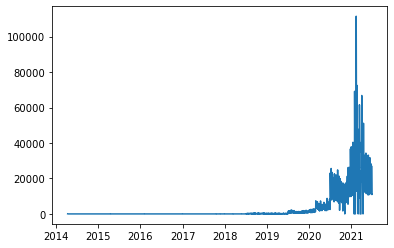

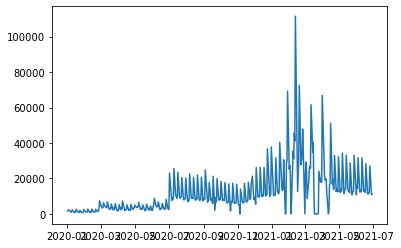

In [60]:
fig,ax = plt.subplots()

ax.plot(bin_df['time'],bin_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

fig,ax = plt.subplots()

ax.plot(tdf['time'],tdf['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()



In [61]:
#//***Aggreate Comments for Training
#//*** Build tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

#loop_list.append(tfidf.fit_transform(input_df['tfidf']))
tfidf_matrix = []
tfidf_list = []
tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(bin_df['body'])


print(f"Built: {round(time.time()-start_time,2)}")

print(tfidf_matrix)
print

Starting tfidf....
Built: 85.42
  (0, 78038)	0.025697858121497493
  (0, 136108)	0.008625342185346496
  (0, 126162)	0.017136593934552802
  (0, 216071)	0.025697858121497493
  (0, 72179)	0.017389748895343376
  (0, 71391)	0.025697858121497493
  (0, 5453)	0.020750359376861278
  (0, 23934)	0.022683819578410803
  (0, 57662)	0.020750359376861278
  (0, 63306)	0.02436412481916975
  (0, 40817)	0.020750359376861278
  (0, 23981)	0.025697858121497493
  (0, 57666)	0.023417825981516757
  (0, 23151)	0.041500718753722556
  (0, 57670)	0.01929699867087304
  (0, 78264)	0.022084092679189017
  (0, 57512)	0.017524028399227547
  (0, 78277)	0.023417825981516757
  (0, 56583)	0.007963592278907772
  (0, 39190)	0.025697858121497493
  (0, 76644)	0.025697858121497493
  (0, 35547)	0.02436412481916975
  (0, 38424)	0.022683819578410803
  (0, 112914)	0.025697858121497493
  (0, 9244)	0.020502251768162467
  :	:
  (1816, 175132)	0.04921315040241827
  (1816, 467791)	0.010589044356159157
  (1816, 174302)	0.00375819644364066
 

<function print>

In [ ]:
tdf = pd.concat([bin_df,pd.DataFrame(tfidf_matrix.toarray())])
del tdf['body']
del tdf['symbol']
tdf


In [86]:
tdf = pd.read_pickle(output_filename)
tdf

created_utc                                               body  \
0     2019-07-24 09:00:25  Index fund tracks the performance of an stock ...   
1     2019-07-24 09:07:24                       No he’s just being sarcastic   
2     2019-07-24 09:08:21  I was in contact with Schwab and they weren't ...   
3     2019-07-24 09:11:00  Reelection is never a concern for the communis...   
4     2019-07-24 09:13:45  For American brokerages, up to $500,000 are SI...   
...                   ...                                                ...   
23585 2019-08-27 12:57:05  I thought when ETFs deviate from true value, A...   
23586 2019-08-27 12:58:06  Ditto. I own Hexo - the branding, marketing, d...   
23587 2019-08-27 12:59:11  Ugh I know! I’ve been patiently waiting for a ...   
23588 2019-08-27 12:59:57  Same here on ACB. Kind of bagholding at this p...   
23589 2019-08-27 13:01:03  Amazon doesn’t care about maximizing profits f...   

                     time    open    high     low  close  volume  
0     2019-07-24 09:00:00  4.0900  4.0900  4.0900  4.090     406  
1     2019-07-24 09:00:00  4.0900  4.0900  4.0900  4.090     406  
2     2019-07-24 09:00:00  4.0900  4.0900  4.0900  4.090     406  
3     2019-07-24 09:00:00  4.0900  4.0900  4.0900  4.090     406  
4     2019-07-24 09:00:00  4.0900  4.0900  4.0900  4.090     406  
...                   ...     ...     ...     ...    ...     ...  
23585 2019-08-27 12:57:00  3.7116  3.7170  3.7116  3.715    9994  
23586 2019-08-27 12:58:00  3.7150  3.7150  3.7150  3.715     900  
23587 2019-08-27 12:59:00  3.7100  3.7168  3.7100  3.715     545  
23588 2019-08-27 12:59:00  3.7100  3.7168  3.7100  3.715     545  
23589 2019-08-27 13:01:00  3.7100  3.7150  3.7000  3.710   10967  

[23590 rows x 8 columns]

In [5]:
comment_times = list(raw_df['created_utc'].sort_values())
stock_times = list(stock_df['time'].sort_values())



In [137]:
for x in stock_times:
    print(x)

2019-07-24 09:00:00
2019-07-24 09:31:00
2019-07-24 09:32:00
2019-07-24 09:33:00
2019-07-24 09:34:00
2019-07-24 09:35:00
2019-07-24 09:36:00
2019-07-24 09:37:00
2019-07-24 09:38:00
2019-07-24 09:39:00
2019-07-24 09:40:00
2019-07-24 09:41:00
2019-07-24 09:42:00
2019-07-24 09:43:00
2019-07-24 09:44:00
2019-07-24 09:45:00
2019-07-24 09:46:00
2019-07-24 09:47:00
2019-07-24 09:48:00
2019-07-24 09:49:00
2019-07-24 09:50:00
2019-07-24 09:51:00
2019-07-24 09:52:00
2019-07-24 09:53:00
2019-07-24 09:54:00
2019-07-24 09:55:00
2019-07-24 09:56:00
2019-07-24 09:57:00
2019-07-24 09:58:00
2019-07-24 09:59:00
2019-07-24 10:00:00
2019-07-24 10:01:00
2019-07-24 10:02:00
2019-07-24 10:03:00
2019-07-24 10:04:00
2019-07-24 10:05:00
2019-07-24 10:06:00
2019-07-24 10:07:00
2019-07-24 10:08:00
2019-07-24 10:09:00
2019-07-24 10:10:00
2019-07-24 10:11:00
2019-07-24 10:12:00
2019-07-24 10:13:00
2019-07-24 10:14:00
2019-07-24 10:15:00
2019-07-24 10:16:00
2019-07-24 10:17:00
2019-07-24 10:18:00
2019-07-24 10:19:00


2019-08-02 13:45:00
2019-08-02 13:46:00
2019-08-02 13:47:00
2019-08-02 13:48:00
2019-08-02 13:49:00
2019-08-02 13:50:00
2019-08-02 13:51:00
2019-08-02 13:52:00
2019-08-02 13:53:00
2019-08-02 13:54:00
2019-08-02 13:55:00
2019-08-02 13:56:00
2019-08-02 13:57:00
2019-08-02 13:58:00
2019-08-02 13:59:00
2019-08-02 14:00:00
2019-08-02 14:01:00
2019-08-02 14:02:00
2019-08-02 14:03:00
2019-08-02 14:04:00
2019-08-02 14:05:00
2019-08-02 14:06:00
2019-08-02 14:07:00
2019-08-02 14:08:00
2019-08-02 14:09:00
2019-08-02 14:10:00
2019-08-02 14:11:00
2019-08-02 14:12:00
2019-08-02 14:13:00
2019-08-02 14:14:00
2019-08-02 14:15:00
2019-08-02 14:16:00
2019-08-02 14:17:00
2019-08-02 14:18:00
2019-08-02 14:19:00
2019-08-02 14:20:00
2019-08-02 14:21:00
2019-08-02 14:22:00
2019-08-02 14:23:00
2019-08-02 14:24:00
2019-08-02 14:25:00
2019-08-02 14:26:00
2019-08-02 14:27:00
2019-08-02 14:28:00
2019-08-02 14:29:00
2019-08-02 14:30:00
2019-08-02 14:31:00
2019-08-02 14:32:00
2019-08-02 14:33:00
2019-08-02 14:34:00


2019-08-14 11:25:00
2019-08-14 11:26:00
2019-08-14 11:27:00
2019-08-14 11:28:00
2019-08-14 11:29:00
2019-08-14 11:30:00
2019-08-14 11:31:00
2019-08-14 11:32:00
2019-08-14 11:33:00
2019-08-14 11:34:00
2019-08-14 11:35:00
2019-08-14 11:36:00
2019-08-14 11:37:00
2019-08-14 11:38:00
2019-08-14 11:39:00
2019-08-14 11:40:00
2019-08-14 11:41:00
2019-08-14 11:42:00
2019-08-14 11:43:00
2019-08-14 11:44:00
2019-08-14 11:45:00
2019-08-14 11:46:00
2019-08-14 11:47:00
2019-08-14 11:48:00
2019-08-14 11:49:00
2019-08-14 11:50:00
2019-08-14 11:51:00
2019-08-14 11:52:00
2019-08-14 11:53:00
2019-08-14 11:54:00
2019-08-14 11:55:00
2019-08-14 11:56:00
2019-08-14 11:57:00
2019-08-14 11:58:00
2019-08-14 11:59:00
2019-08-14 12:00:00
2019-08-14 12:01:00
2019-08-14 12:02:00
2019-08-14 12:03:00
2019-08-14 12:04:00
2019-08-14 12:05:00
2019-08-14 12:06:00
2019-08-14 12:07:00
2019-08-14 12:08:00
2019-08-14 12:09:00
2019-08-14 12:10:00
2019-08-14 12:11:00
2019-08-14 12:12:00
2019-08-14 12:13:00
2019-08-14 12:14:00


2019-08-23 11:52:00
2019-08-23 11:53:00
2019-08-23 11:54:00
2019-08-23 11:55:00
2019-08-23 11:56:00
2019-08-23 11:57:00
2019-08-23 11:58:00
2019-08-23 11:59:00
2019-08-23 12:00:00
2019-08-23 12:01:00
2019-08-23 12:02:00
2019-08-23 12:03:00
2019-08-23 12:04:00
2019-08-23 12:05:00
2019-08-23 12:06:00
2019-08-23 12:07:00
2019-08-23 12:08:00
2019-08-23 12:09:00
2019-08-23 12:10:00
2019-08-23 12:11:00
2019-08-23 12:12:00
2019-08-23 12:13:00
2019-08-23 12:14:00
2019-08-23 12:15:00
2019-08-23 12:16:00
2019-08-23 12:17:00
2019-08-23 12:18:00
2019-08-23 12:19:00
2019-08-23 12:20:00
2019-08-23 12:21:00
2019-08-23 12:22:00
2019-08-23 12:23:00
2019-08-23 12:24:00
2019-08-23 12:25:00
2019-08-23 12:26:00
2019-08-23 12:27:00
2019-08-23 12:28:00
2019-08-23 12:29:00
2019-08-23 12:30:00
2019-08-23 12:31:00
2019-08-23 12:32:00
2019-08-23 12:33:00
2019-08-23 12:34:00
2019-08-23 12:35:00
2019-08-23 12:36:00
2019-08-23 12:37:00
2019-08-23 12:38:00
2019-08-23 12:39:00
2019-08-23 12:40:00
2019-08-23 12:41:00


2019-09-04 12:01:00
2019-09-04 12:02:00
2019-09-04 12:03:00
2019-09-04 12:04:00
2019-09-04 12:05:00
2019-09-04 12:06:00
2019-09-04 12:07:00
2019-09-04 12:08:00
2019-09-04 12:09:00
2019-09-04 12:10:00
2019-09-04 12:11:00
2019-09-04 12:12:00
2019-09-04 12:13:00
2019-09-04 12:14:00
2019-09-04 12:15:00
2019-09-04 12:16:00
2019-09-04 12:17:00
2019-09-04 12:18:00
2019-09-04 12:19:00
2019-09-04 12:20:00
2019-09-04 12:21:00
2019-09-04 12:22:00
2019-09-04 12:23:00
2019-09-04 12:24:00
2019-09-04 12:25:00
2019-09-04 12:26:00
2019-09-04 12:27:00
2019-09-04 12:28:00
2019-09-04 12:29:00
2019-09-04 12:30:00
2019-09-04 12:31:00
2019-09-04 12:32:00
2019-09-04 12:33:00
2019-09-04 12:34:00
2019-09-04 12:35:00
2019-09-04 12:36:00
2019-09-04 12:37:00
2019-09-04 12:38:00
2019-09-04 12:39:00
2019-09-04 12:40:00
2019-09-04 12:41:00
2019-09-04 12:42:00
2019-09-04 12:43:00
2019-09-04 12:44:00
2019-09-04 12:45:00
2019-09-04 12:46:00
2019-09-04 12:47:00
2019-09-04 12:48:00
2019-09-04 12:49:00
2019-09-04 12:50:00


2019-09-12 14:26:00
2019-09-12 14:27:00
2019-09-12 14:28:00
2019-09-12 14:29:00
2019-09-12 14:30:00
2019-09-12 14:31:00
2019-09-12 14:32:00
2019-09-12 14:33:00
2019-09-12 14:34:00
2019-09-12 14:35:00
2019-09-12 14:36:00
2019-09-12 14:37:00
2019-09-12 14:38:00
2019-09-12 14:39:00
2019-09-12 14:40:00
2019-09-12 14:41:00
2019-09-12 14:42:00
2019-09-12 14:43:00
2019-09-12 14:44:00
2019-09-12 14:45:00
2019-09-12 14:46:00
2019-09-12 14:47:00
2019-09-12 14:48:00
2019-09-12 14:49:00
2019-09-12 14:50:00
2019-09-12 14:51:00
2019-09-12 14:52:00
2019-09-12 14:53:00
2019-09-12 14:54:00
2019-09-12 14:55:00
2019-09-12 14:56:00
2019-09-12 14:57:00
2019-09-12 14:58:00
2019-09-12 14:59:00
2019-09-12 15:00:00
2019-09-12 15:01:00
2019-09-12 15:02:00
2019-09-12 15:03:00
2019-09-12 15:04:00
2019-09-12 15:05:00
2019-09-12 15:06:00
2019-09-12 15:07:00
2019-09-12 15:08:00
2019-09-12 15:09:00
2019-09-12 15:10:00
2019-09-12 15:11:00
2019-09-12 15:12:00
2019-09-12 15:13:00
2019-09-12 15:14:00
2019-09-12 15:15:00


2019-09-24 10:25:00
2019-09-24 10:26:00
2019-09-24 10:27:00
2019-09-24 10:28:00
2019-09-24 10:29:00
2019-09-24 10:30:00
2019-09-24 10:31:00
2019-09-24 10:32:00
2019-09-24 10:33:00
2019-09-24 10:34:00
2019-09-24 10:35:00
2019-09-24 10:36:00
2019-09-24 10:37:00
2019-09-24 10:38:00
2019-09-24 10:39:00
2019-09-24 10:40:00
2019-09-24 10:41:00
2019-09-24 10:42:00
2019-09-24 10:43:00
2019-09-24 10:44:00
2019-09-24 10:45:00
2019-09-24 10:46:00
2019-09-24 10:47:00
2019-09-24 10:48:00
2019-09-24 10:49:00
2019-09-24 10:50:00
2019-09-24 10:51:00
2019-09-24 10:52:00
2019-09-24 10:53:00
2019-09-24 10:54:00
2019-09-24 10:55:00
2019-09-24 10:56:00
2019-09-24 10:57:00
2019-09-24 10:58:00
2019-09-24 10:59:00
2019-09-24 11:00:00
2019-09-24 11:01:00
2019-09-24 11:02:00
2019-09-24 11:03:00
2019-09-24 11:04:00
2019-09-24 11:05:00
2019-09-24 11:06:00
2019-09-24 11:07:00
2019-09-24 11:08:00
2019-09-24 11:09:00
2019-09-24 11:10:00
2019-09-24 11:11:00
2019-09-24 11:12:00
2019-09-24 11:13:00
2019-09-24 11:14:00


2019-10-03 14:30:00
2019-10-03 14:31:00
2019-10-03 14:32:00
2019-10-03 14:33:00
2019-10-03 14:34:00
2019-10-03 14:35:00
2019-10-03 14:36:00
2019-10-03 14:37:00
2019-10-03 14:38:00
2019-10-03 14:39:00
2019-10-03 14:40:00
2019-10-03 14:41:00
2019-10-03 14:42:00
2019-10-03 14:43:00
2019-10-03 14:44:00
2019-10-03 14:45:00
2019-10-03 14:46:00
2019-10-03 14:47:00
2019-10-03 14:48:00
2019-10-03 14:49:00
2019-10-03 14:50:00
2019-10-03 14:51:00
2019-10-03 14:52:00
2019-10-03 14:53:00
2019-10-03 14:54:00
2019-10-03 14:55:00
2019-10-03 14:56:00
2019-10-03 14:57:00
2019-10-03 14:58:00
2019-10-03 14:59:00
2019-10-03 15:00:00
2019-10-03 15:01:00
2019-10-03 15:02:00
2019-10-03 15:03:00
2019-10-03 15:04:00
2019-10-03 15:05:00
2019-10-03 15:06:00
2019-10-03 15:07:00
2019-10-03 15:08:00
2019-10-03 15:09:00
2019-10-03 15:10:00
2019-10-03 15:11:00
2019-10-03 15:12:00
2019-10-03 15:13:00
2019-10-03 15:14:00
2019-10-03 15:15:00
2019-10-03 15:16:00
2019-10-03 15:17:00
2019-10-03 15:18:00
2019-10-03 15:19:00


2019-10-15 13:38:00
2019-10-15 13:39:00
2019-10-15 13:40:00
2019-10-15 13:41:00
2019-10-15 13:42:00
2019-10-15 13:43:00
2019-10-15 13:44:00
2019-10-15 13:45:00
2019-10-15 13:46:00
2019-10-15 13:47:00
2019-10-15 13:48:00
2019-10-15 13:49:00
2019-10-15 13:50:00
2019-10-15 13:51:00
2019-10-15 13:52:00
2019-10-15 13:53:00
2019-10-15 13:54:00
2019-10-15 13:55:00
2019-10-15 13:56:00
2019-10-15 13:57:00
2019-10-15 13:58:00
2019-10-15 13:59:00
2019-10-15 14:00:00
2019-10-15 14:01:00
2019-10-15 14:02:00
2019-10-15 14:03:00
2019-10-15 14:04:00
2019-10-15 14:05:00
2019-10-15 14:06:00
2019-10-15 14:07:00
2019-10-15 14:08:00
2019-10-15 14:09:00
2019-10-15 14:10:00
2019-10-15 14:11:00
2019-10-15 14:12:00
2019-10-15 14:13:00
2019-10-15 14:14:00
2019-10-15 14:15:00
2019-10-15 14:16:00
2019-10-15 14:17:00
2019-10-15 14:18:00
2019-10-15 14:19:00
2019-10-15 14:20:00
2019-10-15 14:21:00
2019-10-15 14:22:00
2019-10-15 14:23:00
2019-10-15 14:24:00
2019-10-15 14:25:00
2019-10-15 14:26:00
2019-10-15 14:27:00


2019-10-25 11:26:00
2019-10-25 11:27:00
2019-10-25 11:28:00
2019-10-25 11:29:00
2019-10-25 11:30:00
2019-10-25 11:31:00
2019-10-25 11:32:00
2019-10-25 11:33:00
2019-10-25 11:34:00
2019-10-25 11:35:00
2019-10-25 11:36:00
2019-10-25 11:37:00
2019-10-25 11:38:00
2019-10-25 11:39:00
2019-10-25 11:40:00
2019-10-25 11:41:00
2019-10-25 11:42:00
2019-10-25 11:43:00
2019-10-25 11:44:00
2019-10-25 11:45:00
2019-10-25 11:46:00
2019-10-25 11:47:00
2019-10-25 11:48:00
2019-10-25 11:49:00
2019-10-25 11:50:00
2019-10-25 11:51:00
2019-10-25 11:52:00
2019-10-25 11:53:00
2019-10-25 11:54:00
2019-10-25 11:55:00
2019-10-25 11:56:00
2019-10-25 11:57:00
2019-10-25 11:58:00
2019-10-25 11:59:00
2019-10-25 12:00:00
2019-10-25 12:01:00
2019-10-25 12:02:00
2019-10-25 12:03:00
2019-10-25 12:04:00
2019-10-25 12:05:00
2019-10-25 12:06:00
2019-10-25 12:07:00
2019-10-25 12:08:00
2019-10-25 12:09:00
2019-10-25 12:10:00
2019-10-25 12:11:00
2019-10-25 12:12:00
2019-10-25 12:13:00
2019-10-25 12:14:00
2019-10-25 12:15:00


2019-11-06 11:16:00
2019-11-06 11:17:00
2019-11-06 11:18:00
2019-11-06 11:19:00
2019-11-06 11:20:00
2019-11-06 11:21:00
2019-11-06 11:22:00
2019-11-06 11:23:00
2019-11-06 11:24:00
2019-11-06 11:26:00
2019-11-06 11:27:00
2019-11-06 11:28:00
2019-11-06 11:29:00
2019-11-06 11:30:00
2019-11-06 11:31:00
2019-11-06 11:32:00
2019-11-06 11:33:00
2019-11-06 11:34:00
2019-11-06 11:35:00
2019-11-06 11:36:00
2019-11-06 11:37:00
2019-11-06 11:38:00
2019-11-06 11:39:00
2019-11-06 11:40:00
2019-11-06 11:41:00
2019-11-06 11:42:00
2019-11-06 11:43:00
2019-11-06 11:44:00
2019-11-06 11:45:00
2019-11-06 11:46:00
2019-11-06 11:47:00
2019-11-06 11:48:00
2019-11-06 11:49:00
2019-11-06 11:50:00
2019-11-06 11:51:00
2019-11-06 11:52:00
2019-11-06 11:53:00
2019-11-06 11:54:00
2019-11-06 11:55:00
2019-11-06 11:56:00
2019-11-06 11:57:00
2019-11-06 11:58:00
2019-11-06 11:59:00
2019-11-06 12:00:00
2019-11-06 12:01:00
2019-11-06 12:02:00
2019-11-06 12:03:00
2019-11-06 12:04:00
2019-11-06 12:05:00
2019-11-06 12:06:00


2019-11-19 10:33:00
2019-11-19 10:34:00
2019-11-19 10:35:00
2019-11-19 10:36:00
2019-11-19 10:37:00
2019-11-19 10:38:00
2019-11-19 10:39:00
2019-11-19 10:40:00
2019-11-19 10:41:00
2019-11-19 10:42:00
2019-11-19 10:43:00
2019-11-19 10:44:00
2019-11-19 10:45:00
2019-11-19 10:46:00
2019-11-19 10:47:00
2019-11-19 10:48:00
2019-11-19 10:49:00
2019-11-19 10:50:00
2019-11-19 10:51:00
2019-11-19 10:52:00
2019-11-19 10:53:00
2019-11-19 10:54:00
2019-11-19 10:55:00
2019-11-19 10:56:00
2019-11-19 10:57:00
2019-11-19 10:58:00
2019-11-19 10:59:00
2019-11-19 11:00:00
2019-11-19 11:01:00
2019-11-19 11:02:00
2019-11-19 11:03:00
2019-11-19 11:04:00
2019-11-19 11:05:00
2019-11-19 11:06:00
2019-11-19 11:07:00
2019-11-19 11:08:00
2019-11-19 11:09:00
2019-11-19 11:10:00
2019-11-19 11:11:00
2019-11-19 11:12:00
2019-11-19 11:13:00
2019-11-19 11:14:00
2019-11-19 11:15:00
2019-11-19 11:16:00
2019-11-19 11:17:00
2019-11-19 11:18:00
2019-11-19 11:19:00
2019-11-19 11:20:00
2019-11-19 11:21:00
2019-11-19 11:22:00


2019-12-02 11:20:00
2019-12-02 11:21:00
2019-12-02 11:22:00
2019-12-02 11:23:00
2019-12-02 11:24:00
2019-12-02 11:25:00
2019-12-02 11:26:00
2019-12-02 11:27:00
2019-12-02 11:28:00
2019-12-02 11:29:00
2019-12-02 11:30:00
2019-12-02 11:31:00
2019-12-02 11:32:00
2019-12-02 11:33:00
2019-12-02 11:34:00
2019-12-02 11:35:00
2019-12-02 11:36:00
2019-12-02 11:37:00
2019-12-02 11:38:00
2019-12-02 11:39:00
2019-12-02 11:40:00
2019-12-02 11:41:00
2019-12-02 11:42:00
2019-12-02 11:43:00
2019-12-02 11:44:00
2019-12-02 11:45:00
2019-12-02 11:46:00
2019-12-02 11:47:00
2019-12-02 11:48:00
2019-12-02 11:49:00
2019-12-02 11:50:00
2019-12-02 11:51:00
2019-12-02 11:52:00
2019-12-02 11:53:00
2019-12-02 11:54:00
2019-12-02 11:55:00
2019-12-02 11:56:00
2019-12-02 11:57:00
2019-12-02 11:58:00
2019-12-02 11:59:00
2019-12-02 12:00:00
2019-12-02 12:01:00
2019-12-02 12:02:00
2019-12-02 12:03:00
2019-12-02 12:04:00
2019-12-02 12:05:00
2019-12-02 12:06:00
2019-12-02 12:07:00
2019-12-02 12:08:00
2019-12-02 12:09:00


2019-12-11 17:22:00
2019-12-11 17:25:00
2019-12-11 17:28:00
2019-12-11 17:31:00
2019-12-11 17:32:00
2019-12-11 17:52:00
2019-12-11 18:03:00
2019-12-11 18:25:00
2019-12-11 18:27:00
2019-12-11 18:28:00
2019-12-11 18:31:00
2019-12-11 18:32:00
2019-12-11 18:33:00
2019-12-11 18:34:00
2019-12-11 18:55:00
2019-12-12 07:56:00
2019-12-12 08:01:00
2019-12-12 08:03:00
2019-12-12 08:04:00
2019-12-12 08:12:00
2019-12-12 08:15:00
2019-12-12 08:16:00
2019-12-12 08:17:00
2019-12-12 08:34:00
2019-12-12 08:41:00
2019-12-12 09:02:00
2019-12-12 09:03:00
2019-12-12 09:11:00
2019-12-12 09:12:00
2019-12-12 09:16:00
2019-12-12 09:18:00
2019-12-12 09:21:00
2019-12-12 09:24:00
2019-12-12 09:28:00
2019-12-12 09:31:00
2019-12-12 09:32:00
2019-12-12 09:33:00
2019-12-12 09:34:00
2019-12-12 09:35:00
2019-12-12 09:36:00
2019-12-12 09:37:00
2019-12-12 09:38:00
2019-12-12 09:39:00
2019-12-12 09:40:00
2019-12-12 09:41:00
2019-12-12 09:42:00
2019-12-12 09:43:00
2019-12-12 09:44:00
2019-12-12 09:45:00
2019-12-12 09:46:00


2019-12-23 13:48:00
2019-12-23 13:49:00
2019-12-23 13:50:00
2019-12-23 13:51:00
2019-12-23 13:52:00
2019-12-23 13:53:00
2019-12-23 13:54:00
2019-12-23 13:55:00
2019-12-23 13:56:00
2019-12-23 13:57:00
2019-12-23 13:58:00
2019-12-23 13:59:00
2019-12-23 14:00:00
2019-12-23 14:01:00
2019-12-23 14:02:00
2019-12-23 14:03:00
2019-12-23 14:04:00
2019-12-23 14:05:00
2019-12-23 14:06:00
2019-12-23 14:07:00
2019-12-23 14:08:00
2019-12-23 14:09:00
2019-12-23 14:10:00
2019-12-23 14:11:00
2019-12-23 14:12:00
2019-12-23 14:13:00
2019-12-23 14:14:00
2019-12-23 14:15:00
2019-12-23 14:16:00
2019-12-23 14:17:00
2019-12-23 14:18:00
2019-12-23 14:19:00
2019-12-23 14:20:00
2019-12-23 14:21:00
2019-12-23 14:22:00
2019-12-23 14:23:00
2019-12-23 14:24:00
2019-12-23 14:25:00
2019-12-23 14:26:00
2019-12-23 14:27:00
2019-12-23 14:28:00
2019-12-23 14:29:00
2019-12-23 14:30:00
2019-12-23 14:31:00
2019-12-23 14:32:00
2019-12-23 14:33:00
2019-12-23 14:34:00
2019-12-23 14:35:00
2019-12-23 14:36:00
2019-12-23 14:37:00


2020-01-07 13:13:00
2020-01-07 13:14:00
2020-01-07 13:15:00
2020-01-07 13:16:00
2020-01-07 13:17:00
2020-01-07 13:18:00
2020-01-07 13:19:00
2020-01-07 13:20:00
2020-01-07 13:21:00
2020-01-07 13:22:00
2020-01-07 13:23:00
2020-01-07 13:24:00
2020-01-07 13:25:00
2020-01-07 13:26:00
2020-01-07 13:27:00
2020-01-07 13:28:00
2020-01-07 13:29:00
2020-01-07 13:30:00
2020-01-07 13:31:00
2020-01-07 13:32:00
2020-01-07 13:33:00
2020-01-07 13:34:00
2020-01-07 13:35:00
2020-01-07 13:36:00
2020-01-07 13:37:00
2020-01-07 13:38:00
2020-01-07 13:39:00
2020-01-07 13:40:00
2020-01-07 13:41:00
2020-01-07 13:42:00
2020-01-07 13:43:00
2020-01-07 13:44:00
2020-01-07 13:45:00
2020-01-07 13:46:00
2020-01-07 13:47:00
2020-01-07 13:48:00
2020-01-07 13:49:00
2020-01-07 13:50:00
2020-01-07 13:51:00
2020-01-07 13:52:00
2020-01-07 13:53:00
2020-01-07 13:54:00
2020-01-07 13:55:00
2020-01-07 13:56:00
2020-01-07 13:57:00
2020-01-07 13:58:00
2020-01-07 13:59:00
2020-01-07 14:00:00
2020-01-07 14:01:00
2020-01-07 14:02:00


2020-01-16 15:59:00
2020-01-16 16:00:00
2020-01-16 16:01:00
2020-01-16 16:02:00
2020-01-16 16:43:00
2020-01-16 17:02:00
2020-01-16 17:18:00
2020-01-16 17:21:00
2020-01-16 17:34:00
2020-01-17 09:09:00
2020-01-17 09:12:00
2020-01-17 09:26:00
2020-01-17 09:31:00
2020-01-17 09:32:00
2020-01-17 09:33:00
2020-01-17 09:34:00
2020-01-17 09:35:00
2020-01-17 09:36:00
2020-01-17 09:37:00
2020-01-17 09:38:00
2020-01-17 09:39:00
2020-01-17 09:40:00
2020-01-17 09:41:00
2020-01-17 09:42:00
2020-01-17 09:43:00
2020-01-17 09:44:00
2020-01-17 09:45:00
2020-01-17 09:46:00
2020-01-17 09:47:00
2020-01-17 09:48:00
2020-01-17 09:49:00
2020-01-17 09:50:00
2020-01-17 09:51:00
2020-01-17 09:52:00
2020-01-17 09:53:00
2020-01-17 09:54:00
2020-01-17 09:55:00
2020-01-17 09:56:00
2020-01-17 09:57:00
2020-01-17 09:58:00
2020-01-17 09:59:00
2020-01-17 10:00:00
2020-01-17 10:01:00
2020-01-17 10:02:00
2020-01-17 10:03:00
2020-01-17 10:04:00
2020-01-17 10:05:00
2020-01-17 10:06:00
2020-01-17 10:07:00
2020-01-17 10:08:00


2020-01-29 14:55:00
2020-01-29 14:56:00
2020-01-29 14:57:00
2020-01-29 14:58:00
2020-01-29 14:59:00
2020-01-29 15:00:00
2020-01-29 15:01:00
2020-01-29 15:02:00
2020-01-29 15:03:00
2020-01-29 15:04:00
2020-01-29 15:05:00
2020-01-29 15:06:00
2020-01-29 15:07:00
2020-01-29 15:08:00
2020-01-29 15:09:00
2020-01-29 15:10:00
2020-01-29 15:11:00
2020-01-29 15:12:00
2020-01-29 15:13:00
2020-01-29 15:15:00
2020-01-29 15:16:00
2020-01-29 15:17:00
2020-01-29 15:18:00
2020-01-29 15:19:00
2020-01-29 15:20:00
2020-01-29 15:21:00
2020-01-29 15:22:00
2020-01-29 15:23:00
2020-01-29 15:24:00
2020-01-29 15:25:00
2020-01-29 15:26:00
2020-01-29 15:27:00
2020-01-29 15:28:00
2020-01-29 15:29:00
2020-01-29 15:30:00
2020-01-29 15:31:00
2020-01-29 15:32:00
2020-01-29 15:33:00
2020-01-29 15:34:00
2020-01-29 15:35:00
2020-01-29 15:36:00
2020-01-29 15:37:00
2020-01-29 15:38:00
2020-01-29 15:39:00
2020-01-29 15:40:00
2020-01-29 15:41:00
2020-01-29 15:42:00
2020-01-29 15:43:00
2020-01-29 15:44:00
2020-01-29 15:45:00


2020-02-10 15:11:00
2020-02-10 15:12:00
2020-02-10 15:13:00
2020-02-10 15:14:00
2020-02-10 15:16:00
2020-02-10 15:17:00
2020-02-10 15:19:00
2020-02-10 15:20:00
2020-02-10 15:21:00
2020-02-10 15:22:00
2020-02-10 15:23:00
2020-02-10 15:24:00
2020-02-10 15:25:00
2020-02-10 15:26:00
2020-02-10 15:27:00
2020-02-10 15:28:00
2020-02-10 15:29:00
2020-02-10 15:30:00
2020-02-10 15:31:00
2020-02-10 15:32:00
2020-02-10 15:33:00
2020-02-10 15:34:00
2020-02-10 15:35:00
2020-02-10 15:36:00
2020-02-10 15:37:00
2020-02-10 15:38:00
2020-02-10 15:39:00
2020-02-10 15:40:00
2020-02-10 15:41:00
2020-02-10 15:42:00
2020-02-10 15:43:00
2020-02-10 15:44:00
2020-02-10 15:45:00
2020-02-10 15:46:00
2020-02-10 15:47:00
2020-02-10 15:48:00
2020-02-10 15:49:00
2020-02-10 15:50:00
2020-02-10 15:51:00
2020-02-10 15:52:00
2020-02-10 15:53:00
2020-02-10 15:54:00
2020-02-10 15:55:00
2020-02-10 15:56:00
2020-02-10 15:57:00
2020-02-10 15:58:00
2020-02-10 15:59:00
2020-02-10 16:00:00
2020-02-10 16:01:00
2020-02-10 16:04:00


2020-02-24 12:55:00
2020-02-24 12:56:00
2020-02-24 12:57:00
2020-02-24 12:58:00
2020-02-24 12:59:00
2020-02-24 13:00:00
2020-02-24 13:01:00
2020-02-24 13:02:00
2020-02-24 13:03:00
2020-02-24 13:04:00
2020-02-24 13:05:00
2020-02-24 13:06:00
2020-02-24 13:07:00
2020-02-24 13:08:00
2020-02-24 13:09:00
2020-02-24 13:10:00
2020-02-24 13:11:00
2020-02-24 13:12:00
2020-02-24 13:13:00
2020-02-24 13:14:00
2020-02-24 13:15:00
2020-02-24 13:16:00
2020-02-24 13:17:00
2020-02-24 13:18:00
2020-02-24 13:19:00
2020-02-24 13:20:00
2020-02-24 13:21:00
2020-02-24 13:22:00
2020-02-24 13:23:00
2020-02-24 13:24:00
2020-02-24 13:25:00
2020-02-24 13:26:00
2020-02-24 13:27:00
2020-02-24 13:28:00
2020-02-24 13:29:00
2020-02-24 13:30:00
2020-02-24 13:31:00
2020-02-24 13:32:00
2020-02-24 13:33:00
2020-02-24 13:34:00
2020-02-24 13:35:00
2020-02-24 13:36:00
2020-02-24 13:37:00
2020-02-24 13:38:00
2020-02-24 13:39:00
2020-02-24 13:40:00
2020-02-24 13:41:00
2020-02-24 13:42:00
2020-02-24 13:43:00
2020-02-24 13:44:00


2020-03-05 10:55:00
2020-03-05 10:56:00
2020-03-05 10:57:00
2020-03-05 10:58:00
2020-03-05 10:59:00
2020-03-05 11:00:00
2020-03-05 11:01:00
2020-03-05 11:02:00
2020-03-05 11:03:00
2020-03-05 11:04:00
2020-03-05 11:05:00
2020-03-05 11:06:00
2020-03-05 11:07:00
2020-03-05 11:08:00
2020-03-05 11:09:00
2020-03-05 11:10:00
2020-03-05 11:11:00
2020-03-05 11:12:00
2020-03-05 11:13:00
2020-03-05 11:14:00
2020-03-05 11:15:00
2020-03-05 11:16:00
2020-03-05 11:17:00
2020-03-05 11:18:00
2020-03-05 11:19:00
2020-03-05 11:20:00
2020-03-05 11:21:00
2020-03-05 11:22:00
2020-03-05 11:23:00
2020-03-05 11:24:00
2020-03-05 11:25:00
2020-03-05 11:26:00
2020-03-05 11:27:00
2020-03-05 11:28:00
2020-03-05 11:29:00
2020-03-05 11:30:00
2020-03-05 11:31:00
2020-03-05 11:32:00
2020-03-05 11:33:00
2020-03-05 11:34:00
2020-03-05 11:35:00
2020-03-05 11:36:00
2020-03-05 11:37:00
2020-03-05 11:38:00
2020-03-05 11:39:00
2020-03-05 11:40:00
2020-03-05 11:41:00
2020-03-05 11:42:00
2020-03-05 11:43:00
2020-03-05 11:44:00


2020-03-16 12:52:00
2020-03-16 12:53:00
2020-03-16 12:54:00
2020-03-16 12:55:00
2020-03-16 12:56:00
2020-03-16 12:57:00
2020-03-16 12:58:00
2020-03-16 12:59:00
2020-03-16 13:00:00
2020-03-16 13:01:00
2020-03-16 13:02:00
2020-03-16 13:03:00
2020-03-16 13:04:00
2020-03-16 13:05:00
2020-03-16 13:06:00
2020-03-16 13:07:00
2020-03-16 13:08:00
2020-03-16 13:09:00
2020-03-16 13:10:00
2020-03-16 13:11:00
2020-03-16 13:12:00
2020-03-16 13:13:00
2020-03-16 13:14:00
2020-03-16 13:15:00
2020-03-16 13:16:00
2020-03-16 13:17:00
2020-03-16 13:18:00
2020-03-16 13:19:00
2020-03-16 13:20:00
2020-03-16 13:21:00
2020-03-16 13:22:00
2020-03-16 13:23:00
2020-03-16 13:24:00
2020-03-16 13:25:00
2020-03-16 13:26:00
2020-03-16 13:27:00
2020-03-16 13:28:00
2020-03-16 13:29:00
2020-03-16 13:30:00
2020-03-16 13:31:00
2020-03-16 13:32:00
2020-03-16 13:33:00
2020-03-16 13:34:00
2020-03-16 13:35:00
2020-03-16 13:36:00
2020-03-16 13:37:00
2020-03-16 13:38:00
2020-03-16 13:39:00
2020-03-16 13:40:00
2020-03-16 13:41:00


2020-03-26 14:58:00
2020-03-26 14:59:00
2020-03-26 15:00:00
2020-03-26 15:01:00
2020-03-26 15:02:00
2020-03-26 15:03:00
2020-03-26 15:04:00
2020-03-26 15:05:00
2020-03-26 15:06:00
2020-03-26 15:07:00
2020-03-26 15:08:00
2020-03-26 15:09:00
2020-03-26 15:10:00
2020-03-26 15:11:00
2020-03-26 15:12:00
2020-03-26 15:13:00
2020-03-26 15:14:00
2020-03-26 15:15:00
2020-03-26 15:16:00
2020-03-26 15:17:00
2020-03-26 15:18:00
2020-03-26 15:19:00
2020-03-26 15:20:00
2020-03-26 15:21:00
2020-03-26 15:22:00
2020-03-26 15:23:00
2020-03-26 15:24:00
2020-03-26 15:25:00
2020-03-26 15:26:00
2020-03-26 15:27:00
2020-03-26 15:28:00
2020-03-26 15:29:00
2020-03-26 15:30:00
2020-03-26 15:31:00
2020-03-26 15:32:00
2020-03-26 15:33:00
2020-03-26 15:34:00
2020-03-26 15:35:00
2020-03-26 15:36:00
2020-03-26 15:37:00
2020-03-26 15:38:00
2020-03-26 15:39:00
2020-03-26 15:40:00
2020-03-26 15:41:00
2020-03-26 15:42:00
2020-03-26 15:43:00
2020-03-26 15:44:00
2020-03-26 15:45:00
2020-03-26 15:46:00
2020-03-26 15:47:00


2020-04-06 15:25:00
2020-04-06 15:26:00
2020-04-06 15:27:00
2020-04-06 15:28:00
2020-04-06 15:29:00
2020-04-06 15:30:00
2020-04-06 15:31:00
2020-04-06 15:32:00
2020-04-06 15:33:00
2020-04-06 15:34:00
2020-04-06 15:35:00
2020-04-06 15:36:00
2020-04-06 15:37:00
2020-04-06 15:38:00
2020-04-06 15:39:00
2020-04-06 15:40:00
2020-04-06 15:41:00
2020-04-06 15:42:00
2020-04-06 15:43:00
2020-04-06 15:44:00
2020-04-06 15:45:00
2020-04-06 15:46:00
2020-04-06 15:47:00
2020-04-06 15:48:00
2020-04-06 15:49:00
2020-04-06 15:50:00
2020-04-06 15:51:00
2020-04-06 15:52:00
2020-04-06 15:53:00
2020-04-06 15:54:00
2020-04-06 15:55:00
2020-04-06 15:56:00
2020-04-06 15:57:00
2020-04-06 15:58:00
2020-04-06 15:59:00
2020-04-06 16:00:00
2020-04-06 16:03:00
2020-04-06 16:04:00
2020-04-06 16:26:00
2020-04-06 16:37:00
2020-04-06 16:39:00
2020-04-06 16:57:00
2020-04-06 17:02:00
2020-04-06 17:10:00
2020-04-06 17:20:00
2020-04-06 17:26:00
2020-04-06 17:29:00
2020-04-06 17:44:00
2020-04-06 17:57:00
2020-04-06 18:17:00


2020-04-16 14:25:00
2020-04-16 14:26:00
2020-04-16 14:27:00
2020-04-16 14:28:00
2020-04-16 14:29:00
2020-04-16 14:30:00
2020-04-16 14:31:00
2020-04-16 14:32:00
2020-04-16 14:33:00
2020-04-16 14:34:00
2020-04-16 14:35:00
2020-04-16 14:36:00
2020-04-16 14:37:00
2020-04-16 14:38:00
2020-04-16 14:39:00
2020-04-16 14:40:00
2020-04-16 14:41:00
2020-04-16 14:42:00
2020-04-16 14:43:00
2020-04-16 14:44:00
2020-04-16 14:45:00
2020-04-16 14:46:00
2020-04-16 14:47:00
2020-04-16 14:48:00
2020-04-16 14:49:00
2020-04-16 14:50:00
2020-04-16 14:51:00
2020-04-16 14:52:00
2020-04-16 14:53:00
2020-04-16 14:54:00
2020-04-16 14:55:00
2020-04-16 14:56:00
2020-04-16 14:57:00
2020-04-16 14:58:00
2020-04-16 14:59:00
2020-04-16 15:00:00
2020-04-16 15:01:00
2020-04-16 15:02:00
2020-04-16 15:03:00
2020-04-16 15:04:00
2020-04-16 15:05:00
2020-04-16 15:06:00
2020-04-16 15:07:00
2020-04-16 15:08:00
2020-04-16 15:09:00
2020-04-16 15:10:00
2020-04-16 15:11:00
2020-04-16 15:12:00
2020-04-16 15:13:00
2020-04-16 15:14:00


2020-04-28 10:39:00
2020-04-28 10:40:00
2020-04-28 10:41:00
2020-04-28 10:42:00
2020-04-28 10:43:00
2020-04-28 10:44:00
2020-04-28 10:45:00
2020-04-28 10:46:00
2020-04-28 10:47:00
2020-04-28 10:48:00
2020-04-28 10:49:00
2020-04-28 10:50:00
2020-04-28 10:51:00
2020-04-28 10:52:00
2020-04-28 10:53:00
2020-04-28 10:54:00
2020-04-28 10:55:00
2020-04-28 10:56:00
2020-04-28 10:57:00
2020-04-28 10:58:00
2020-04-28 10:59:00
2020-04-28 11:00:00
2020-04-28 11:01:00
2020-04-28 11:02:00
2020-04-28 11:03:00
2020-04-28 11:04:00
2020-04-28 11:05:00
2020-04-28 11:06:00
2020-04-28 11:07:00
2020-04-28 11:08:00
2020-04-28 11:09:00
2020-04-28 11:10:00
2020-04-28 11:11:00
2020-04-28 11:12:00
2020-04-28 11:13:00
2020-04-28 11:14:00
2020-04-28 11:15:00
2020-04-28 11:16:00
2020-04-28 11:17:00
2020-04-28 11:18:00
2020-04-28 11:19:00
2020-04-28 11:20:00
2020-04-28 11:21:00
2020-04-28 11:22:00
2020-04-28 11:23:00
2020-04-28 11:24:00
2020-04-28 11:25:00
2020-04-28 11:26:00
2020-04-28 11:27:00
2020-04-28 11:28:00


2020-05-07 13:36:00
2020-05-07 13:37:00
2020-05-07 13:38:00
2020-05-07 13:40:00
2020-05-07 13:41:00
2020-05-07 13:42:00
2020-05-07 13:43:00
2020-05-07 13:46:00
2020-05-07 13:47:00
2020-05-07 13:48:00
2020-05-07 13:49:00
2020-05-07 13:53:00
2020-05-07 13:56:00
2020-05-07 13:57:00
2020-05-07 13:58:00
2020-05-07 14:00:00
2020-05-07 14:01:00
2020-05-07 14:02:00
2020-05-07 14:03:00
2020-05-07 14:04:00
2020-05-07 14:05:00
2020-05-07 14:06:00
2020-05-07 14:07:00
2020-05-07 14:08:00
2020-05-07 14:10:00
2020-05-07 14:11:00
2020-05-07 14:12:00
2020-05-07 14:13:00
2020-05-07 14:14:00
2020-05-07 14:15:00
2020-05-07 14:16:00
2020-05-07 14:17:00
2020-05-07 14:18:00
2020-05-07 14:19:00
2020-05-07 14:20:00
2020-05-07 14:21:00
2020-05-07 14:22:00
2020-05-07 14:23:00
2020-05-07 14:24:00
2020-05-07 14:25:00
2020-05-07 14:26:00
2020-05-07 14:27:00
2020-05-07 14:28:00
2020-05-07 14:29:00
2020-05-07 14:30:00
2020-05-07 14:31:00
2020-05-07 14:32:00
2020-05-07 14:33:00
2020-05-07 14:34:00
2020-05-07 14:35:00


2020-05-19 12:30:00
2020-05-19 12:31:00
2020-05-19 12:32:00
2020-05-19 12:33:00
2020-05-19 12:34:00
2020-05-19 12:35:00
2020-05-19 12:36:00
2020-05-19 12:37:00
2020-05-19 12:38:00
2020-05-19 12:39:00
2020-05-19 12:40:00
2020-05-19 12:41:00
2020-05-19 12:42:00
2020-05-19 12:43:00
2020-05-19 12:44:00
2020-05-19 12:45:00
2020-05-19 12:46:00
2020-05-19 12:47:00
2020-05-19 12:48:00
2020-05-19 12:49:00
2020-05-19 12:50:00
2020-05-19 12:51:00
2020-05-19 12:52:00
2020-05-19 12:54:00
2020-05-19 12:55:00
2020-05-19 12:56:00
2020-05-19 12:57:00
2020-05-19 12:58:00
2020-05-19 12:59:00
2020-05-19 13:00:00
2020-05-19 13:01:00
2020-05-19 13:02:00
2020-05-19 13:03:00
2020-05-19 13:04:00
2020-05-19 13:05:00
2020-05-19 13:06:00
2020-05-19 13:07:00
2020-05-19 13:08:00
2020-05-19 13:09:00
2020-05-19 13:10:00
2020-05-19 13:11:00
2020-05-19 13:12:00
2020-05-19 13:13:00
2020-05-19 13:14:00
2020-05-19 13:15:00
2020-05-19 13:16:00
2020-05-19 13:17:00
2020-05-19 13:19:00
2020-05-19 13:20:00
2020-05-19 13:21:00


2020-06-01 12:06:00
2020-06-01 12:07:00
2020-06-01 12:08:00
2020-06-01 12:09:00
2020-06-01 12:10:00
2020-06-01 12:11:00
2020-06-01 12:12:00
2020-06-01 12:13:00
2020-06-01 12:14:00
2020-06-01 12:15:00
2020-06-01 12:16:00
2020-06-01 12:17:00
2020-06-01 12:18:00
2020-06-01 12:20:00
2020-06-01 12:21:00
2020-06-01 12:22:00
2020-06-01 12:23:00
2020-06-01 12:24:00
2020-06-01 12:25:00
2020-06-01 12:26:00
2020-06-01 12:27:00
2020-06-01 12:28:00
2020-06-01 12:29:00
2020-06-01 12:30:00
2020-06-01 12:31:00
2020-06-01 12:32:00
2020-06-01 12:34:00
2020-06-01 12:36:00
2020-06-01 12:37:00
2020-06-01 12:38:00
2020-06-01 12:39:00
2020-06-01 12:40:00
2020-06-01 12:41:00
2020-06-01 12:42:00
2020-06-01 12:43:00
2020-06-01 12:44:00
2020-06-01 12:46:00
2020-06-01 12:48:00
2020-06-01 12:50:00
2020-06-01 12:51:00
2020-06-01 12:52:00
2020-06-01 12:55:00
2020-06-01 12:56:00
2020-06-01 12:57:00
2020-06-01 12:58:00
2020-06-01 12:59:00
2020-06-01 13:00:00
2020-06-01 13:01:00
2020-06-01 13:02:00
2020-06-01 13:03:00


2020-06-09 16:00:00
2020-06-09 16:01:00
2020-06-09 16:02:00
2020-06-09 16:03:00
2020-06-09 16:05:00
2020-06-09 16:06:00
2020-06-09 16:07:00
2020-06-09 16:08:00
2020-06-09 16:09:00
2020-06-09 16:10:00
2020-06-09 16:11:00
2020-06-09 16:12:00
2020-06-09 16:13:00
2020-06-09 16:14:00
2020-06-09 16:15:00
2020-06-09 16:16:00
2020-06-09 16:17:00
2020-06-09 16:18:00
2020-06-09 16:19:00
2020-06-09 16:20:00
2020-06-09 16:21:00
2020-06-09 16:22:00
2020-06-09 16:23:00
2020-06-09 16:24:00
2020-06-09 16:25:00
2020-06-09 16:26:00
2020-06-09 16:27:00
2020-06-09 16:28:00
2020-06-09 16:29:00
2020-06-09 16:30:00
2020-06-09 16:31:00
2020-06-09 16:32:00
2020-06-09 16:33:00
2020-06-09 16:34:00
2020-06-09 16:35:00
2020-06-09 16:36:00
2020-06-09 16:37:00
2020-06-09 16:38:00
2020-06-09 16:39:00
2020-06-09 16:40:00
2020-06-09 16:41:00
2020-06-09 16:42:00
2020-06-09 16:43:00
2020-06-09 16:44:00
2020-06-09 16:45:00
2020-06-09 16:46:00
2020-06-09 16:47:00
2020-06-09 16:48:00
2020-06-09 16:49:00
2020-06-09 16:50:00


2020-06-18 14:01:00
2020-06-18 14:02:00
2020-06-18 14:03:00
2020-06-18 14:05:00
2020-06-18 14:06:00
2020-06-18 14:07:00
2020-06-18 14:08:00
2020-06-18 14:09:00
2020-06-18 14:10:00
2020-06-18 14:11:00
2020-06-18 14:12:00
2020-06-18 14:14:00
2020-06-18 14:15:00
2020-06-18 14:16:00
2020-06-18 14:17:00
2020-06-18 14:18:00
2020-06-18 14:19:00
2020-06-18 14:20:00
2020-06-18 14:21:00
2020-06-18 14:23:00
2020-06-18 14:24:00
2020-06-18 14:25:00
2020-06-18 14:26:00
2020-06-18 14:27:00
2020-06-18 14:29:00
2020-06-18 14:30:00
2020-06-18 14:31:00
2020-06-18 14:32:00
2020-06-18 14:33:00
2020-06-18 14:34:00
2020-06-18 14:35:00
2020-06-18 14:37:00
2020-06-18 14:38:00
2020-06-18 14:40:00
2020-06-18 14:41:00
2020-06-18 14:42:00
2020-06-18 14:43:00
2020-06-18 14:44:00
2020-06-18 14:45:00
2020-06-18 14:46:00
2020-06-18 14:47:00
2020-06-18 14:48:00
2020-06-18 14:49:00
2020-06-18 14:50:00
2020-06-18 14:51:00
2020-06-18 14:52:00
2020-06-18 14:53:00
2020-06-18 14:54:00
2020-06-18 14:55:00
2020-06-18 14:56:00


2020-06-26 14:14:00
2020-06-26 14:15:00
2020-06-26 14:16:00
2020-06-26 14:17:00
2020-06-26 14:18:00
2020-06-26 14:19:00
2020-06-26 14:20:00
2020-06-26 14:22:00
2020-06-26 14:23:00
2020-06-26 14:24:00
2020-06-26 14:25:00
2020-06-26 14:26:00
2020-06-26 14:27:00
2020-06-26 14:28:00
2020-06-26 14:29:00
2020-06-26 14:30:00
2020-06-26 14:31:00
2020-06-26 14:32:00
2020-06-26 14:34:00
2020-06-26 14:35:00
2020-06-26 14:36:00
2020-06-26 14:37:00
2020-06-26 14:38:00
2020-06-26 14:39:00
2020-06-26 14:40:00
2020-06-26 14:41:00
2020-06-26 14:43:00
2020-06-26 14:44:00
2020-06-26 14:45:00
2020-06-26 14:46:00
2020-06-26 14:47:00
2020-06-26 14:48:00
2020-06-26 14:49:00
2020-06-26 14:50:00
2020-06-26 14:51:00
2020-06-26 14:52:00
2020-06-26 14:53:00
2020-06-26 14:54:00
2020-06-26 14:55:00
2020-06-26 14:56:00
2020-06-26 14:57:00
2020-06-26 14:58:00
2020-06-26 14:59:00
2020-06-26 15:00:00
2020-06-26 15:01:00
2020-06-26 15:02:00
2020-06-26 15:03:00
2020-06-26 15:04:00
2020-06-26 15:05:00
2020-06-26 15:06:00


2020-07-09 12:06:00
2020-07-09 12:07:00
2020-07-09 12:08:00
2020-07-09 12:09:00
2020-07-09 12:10:00
2020-07-09 12:11:00
2020-07-09 12:12:00
2020-07-09 12:13:00
2020-07-09 12:14:00
2020-07-09 12:16:00
2020-07-09 12:17:00
2020-07-09 12:18:00
2020-07-09 12:19:00
2020-07-09 12:20:00
2020-07-09 12:21:00
2020-07-09 12:22:00
2020-07-09 12:23:00
2020-07-09 12:24:00
2020-07-09 12:26:00
2020-07-09 12:28:00
2020-07-09 12:29:00
2020-07-09 12:32:00
2020-07-09 12:33:00
2020-07-09 12:34:00
2020-07-09 12:35:00
2020-07-09 12:36:00
2020-07-09 12:37:00
2020-07-09 12:39:00
2020-07-09 12:40:00
2020-07-09 12:41:00
2020-07-09 12:42:00
2020-07-09 12:43:00
2020-07-09 12:45:00
2020-07-09 12:47:00
2020-07-09 12:48:00
2020-07-09 12:49:00
2020-07-09 12:50:00
2020-07-09 12:52:00
2020-07-09 12:54:00
2020-07-09 12:55:00
2020-07-09 12:57:00
2020-07-09 12:58:00
2020-07-09 12:59:00
2020-07-09 13:00:00
2020-07-09 13:01:00
2020-07-09 13:02:00
2020-07-09 13:03:00
2020-07-09 13:04:00
2020-07-09 13:05:00
2020-07-09 13:06:00


2020-07-21 12:08:00
2020-07-21 12:10:00
2020-07-21 12:11:00
2020-07-21 12:12:00
2020-07-21 12:14:00
2020-07-21 12:15:00
2020-07-21 12:16:00
2020-07-21 12:17:00
2020-07-21 12:18:00
2020-07-21 12:19:00
2020-07-21 12:20:00
2020-07-21 12:21:00
2020-07-21 12:22:00
2020-07-21 12:23:00
2020-07-21 12:25:00
2020-07-21 12:26:00
2020-07-21 12:28:00
2020-07-21 12:29:00
2020-07-21 12:32:00
2020-07-21 12:33:00
2020-07-21 12:34:00
2020-07-21 12:35:00
2020-07-21 12:36:00
2020-07-21 12:37:00
2020-07-21 12:38:00
2020-07-21 12:39:00
2020-07-21 12:40:00
2020-07-21 12:41:00
2020-07-21 12:42:00
2020-07-21 12:43:00
2020-07-21 12:45:00
2020-07-21 12:46:00
2020-07-21 12:47:00
2020-07-21 12:48:00
2020-07-21 12:49:00
2020-07-21 12:50:00
2020-07-21 12:51:00
2020-07-21 12:52:00
2020-07-21 12:53:00
2020-07-21 12:55:00
2020-07-21 12:57:00
2020-07-21 12:58:00
2020-07-21 12:59:00
2020-07-21 13:00:00
2020-07-21 13:01:00
2020-07-21 13:02:00
2020-07-21 13:03:00
2020-07-21 13:04:00
2020-07-21 13:05:00
2020-07-21 13:06:00


2020-07-31 13:11:00
2020-07-31 13:12:00
2020-07-31 13:13:00
2020-07-31 13:14:00
2020-07-31 13:15:00
2020-07-31 13:16:00
2020-07-31 13:18:00
2020-07-31 13:19:00
2020-07-31 13:20:00
2020-07-31 13:21:00
2020-07-31 13:22:00
2020-07-31 13:23:00
2020-07-31 13:24:00
2020-07-31 13:26:00
2020-07-31 13:27:00
2020-07-31 13:28:00
2020-07-31 13:30:00
2020-07-31 13:31:00
2020-07-31 13:33:00
2020-07-31 13:34:00
2020-07-31 13:36:00
2020-07-31 13:37:00
2020-07-31 13:38:00
2020-07-31 13:39:00
2020-07-31 13:41:00
2020-07-31 13:42:00
2020-07-31 13:44:00
2020-07-31 13:45:00
2020-07-31 13:47:00
2020-07-31 13:48:00
2020-07-31 13:49:00
2020-07-31 13:50:00
2020-07-31 13:51:00
2020-07-31 13:52:00
2020-07-31 13:53:00
2020-07-31 13:55:00
2020-07-31 13:56:00
2020-07-31 13:57:00
2020-07-31 13:58:00
2020-07-31 13:59:00
2020-07-31 14:00:00
2020-07-31 14:01:00
2020-07-31 14:02:00
2020-07-31 14:03:00
2020-07-31 14:04:00
2020-07-31 14:06:00
2020-07-31 14:09:00
2020-07-31 14:10:00
2020-07-31 14:12:00
2020-07-31 14:14:00


2020-08-12 09:40:00
2020-08-12 09:41:00
2020-08-12 09:42:00
2020-08-12 09:43:00
2020-08-12 09:44:00
2020-08-12 09:45:00
2020-08-12 09:46:00
2020-08-12 09:47:00
2020-08-12 09:48:00
2020-08-12 09:49:00
2020-08-12 09:50:00
2020-08-12 09:51:00
2020-08-12 09:52:00
2020-08-12 09:53:00
2020-08-12 09:54:00
2020-08-12 09:55:00
2020-08-12 09:56:00
2020-08-12 09:57:00
2020-08-12 09:58:00
2020-08-12 09:59:00
2020-08-12 10:00:00
2020-08-12 10:01:00
2020-08-12 10:02:00
2020-08-12 10:03:00
2020-08-12 10:04:00
2020-08-12 10:05:00
2020-08-12 10:06:00
2020-08-12 10:07:00
2020-08-12 10:08:00
2020-08-12 10:09:00
2020-08-12 10:10:00
2020-08-12 10:11:00
2020-08-12 10:12:00
2020-08-12 10:13:00
2020-08-12 10:14:00
2020-08-12 10:15:00
2020-08-12 10:16:00
2020-08-12 10:17:00
2020-08-12 10:18:00
2020-08-12 10:19:00
2020-08-12 10:20:00
2020-08-12 10:21:00
2020-08-12 10:22:00
2020-08-12 10:23:00
2020-08-12 10:24:00
2020-08-12 10:25:00
2020-08-12 10:26:00
2020-08-12 10:27:00
2020-08-12 10:28:00
2020-08-12 10:29:00


2020-08-21 14:31:00
2020-08-21 14:32:00
2020-08-21 14:33:00
2020-08-21 14:34:00
2020-08-21 14:35:00
2020-08-21 14:36:00
2020-08-21 14:37:00
2020-08-21 14:38:00
2020-08-21 14:39:00
2020-08-21 14:40:00
2020-08-21 14:41:00
2020-08-21 14:42:00
2020-08-21 14:43:00
2020-08-21 14:44:00
2020-08-21 14:45:00
2020-08-21 14:46:00
2020-08-21 14:47:00
2020-08-21 14:48:00
2020-08-21 14:49:00
2020-08-21 14:50:00
2020-08-21 14:51:00
2020-08-21 14:52:00
2020-08-21 14:53:00
2020-08-21 14:54:00
2020-08-21 14:55:00
2020-08-21 14:56:00
2020-08-21 14:57:00
2020-08-21 14:58:00
2020-08-21 14:59:00
2020-08-21 15:00:00
2020-08-21 15:01:00
2020-08-21 15:02:00
2020-08-21 15:03:00
2020-08-21 15:04:00
2020-08-21 15:05:00
2020-08-21 15:06:00
2020-08-21 15:07:00
2020-08-21 15:08:00
2020-08-21 15:09:00
2020-08-21 15:10:00
2020-08-21 15:11:00
2020-08-21 15:12:00
2020-08-21 15:13:00
2020-08-21 15:14:00
2020-08-21 15:15:00
2020-08-21 15:16:00
2020-08-21 15:17:00
2020-08-21 15:18:00
2020-08-21 15:19:00
2020-08-21 15:20:00


2020-09-01 11:42:00
2020-09-01 11:43:00
2020-09-01 11:44:00
2020-09-01 11:45:00
2020-09-01 11:46:00
2020-09-01 11:47:00
2020-09-01 11:48:00
2020-09-01 11:49:00
2020-09-01 11:50:00
2020-09-01 11:51:00
2020-09-01 11:52:00
2020-09-01 11:53:00
2020-09-01 11:54:00
2020-09-01 11:55:00
2020-09-01 11:56:00
2020-09-01 11:57:00
2020-09-01 11:58:00
2020-09-01 11:59:00
2020-09-01 12:00:00
2020-09-01 12:01:00
2020-09-01 12:02:00
2020-09-01 12:03:00
2020-09-01 12:04:00
2020-09-01 12:05:00
2020-09-01 12:06:00
2020-09-01 12:07:00
2020-09-01 12:08:00
2020-09-01 12:09:00
2020-09-01 12:10:00
2020-09-01 12:11:00
2020-09-01 12:12:00
2020-09-01 12:13:00
2020-09-01 12:14:00
2020-09-01 12:15:00
2020-09-01 12:16:00
2020-09-01 12:17:00
2020-09-01 12:18:00
2020-09-01 12:19:00
2020-09-01 12:20:00
2020-09-01 12:21:00
2020-09-01 12:22:00
2020-09-01 12:23:00
2020-09-01 12:24:00
2020-09-01 12:25:00
2020-09-01 12:26:00
2020-09-01 12:27:00
2020-09-01 12:28:00
2020-09-01 12:29:00
2020-09-01 12:30:00
2020-09-01 12:31:00


2020-09-09 18:38:00
2020-09-09 18:39:00
2020-09-09 18:40:00
2020-09-09 18:41:00
2020-09-09 18:46:00
2020-09-09 18:47:00
2020-09-09 18:48:00
2020-09-09 18:51:00
2020-09-09 18:54:00
2020-09-09 18:56:00
2020-09-09 18:58:00
2020-09-09 18:59:00
2020-09-09 19:00:00
2020-09-09 19:02:00
2020-09-09 19:05:00
2020-09-09 19:09:00
2020-09-09 19:11:00
2020-09-09 19:13:00
2020-09-09 19:17:00
2020-09-09 19:19:00
2020-09-09 19:20:00
2020-09-09 19:21:00
2020-09-09 19:26:00
2020-09-09 19:28:00
2020-09-09 19:29:00
2020-09-09 19:32:00
2020-09-09 19:33:00
2020-09-09 19:35:00
2020-09-09 19:36:00
2020-09-09 19:43:00
2020-09-09 19:44:00
2020-09-09 19:45:00
2020-09-09 19:47:00
2020-09-09 19:48:00
2020-09-09 19:50:00
2020-09-09 19:51:00
2020-09-09 19:52:00
2020-09-09 19:53:00
2020-09-09 19:54:00
2020-09-09 19:56:00
2020-09-09 19:58:00
2020-09-09 19:59:00
2020-09-09 20:00:00
2020-09-10 04:01:00
2020-09-10 04:05:00
2020-09-10 04:06:00
2020-09-10 04:17:00
2020-09-10 04:18:00
2020-09-10 04:28:00
2020-09-10 04:33:00


2020-09-17 14:45:00
2020-09-17 14:46:00
2020-09-17 14:47:00
2020-09-17 14:48:00
2020-09-17 14:49:00
2020-09-17 14:50:00
2020-09-17 14:51:00
2020-09-17 14:52:00
2020-09-17 14:53:00
2020-09-17 14:54:00
2020-09-17 14:55:00
2020-09-17 14:56:00
2020-09-17 14:57:00
2020-09-17 14:58:00
2020-09-17 14:59:00
2020-09-17 15:00:00
2020-09-17 15:01:00
2020-09-17 15:02:00
2020-09-17 15:03:00
2020-09-17 15:04:00
2020-09-17 15:05:00
2020-09-17 15:06:00
2020-09-17 15:07:00
2020-09-17 15:08:00
2020-09-17 15:09:00
2020-09-17 15:10:00
2020-09-17 15:11:00
2020-09-17 15:12:00
2020-09-17 15:13:00
2020-09-17 15:14:00
2020-09-17 15:15:00
2020-09-17 15:16:00
2020-09-17 15:17:00
2020-09-17 15:18:00
2020-09-17 15:19:00
2020-09-17 15:20:00
2020-09-17 15:21:00
2020-09-17 15:22:00
2020-09-17 15:23:00
2020-09-17 15:24:00
2020-09-17 15:25:00
2020-09-17 15:26:00
2020-09-17 15:27:00
2020-09-17 15:28:00
2020-09-17 15:29:00
2020-09-17 15:30:00
2020-09-17 15:31:00
2020-09-17 15:32:00
2020-09-17 15:33:00
2020-09-17 15:34:00


2020-09-24 15:09:00
2020-09-24 15:10:00
2020-09-24 15:11:00
2020-09-24 15:12:00
2020-09-24 15:13:00
2020-09-24 15:14:00
2020-09-24 15:15:00
2020-09-24 15:16:00
2020-09-24 15:17:00
2020-09-24 15:18:00
2020-09-24 15:19:00
2020-09-24 15:20:00
2020-09-24 15:21:00
2020-09-24 15:22:00
2020-09-24 15:23:00
2020-09-24 15:24:00
2020-09-24 15:25:00
2020-09-24 15:26:00
2020-09-24 15:27:00
2020-09-24 15:28:00
2020-09-24 15:29:00
2020-09-24 15:30:00
2020-09-24 15:31:00
2020-09-24 15:32:00
2020-09-24 15:33:00
2020-09-24 15:34:00
2020-09-24 15:35:00
2020-09-24 15:36:00
2020-09-24 15:37:00
2020-09-24 15:38:00
2020-09-24 15:39:00
2020-09-24 15:40:00
2020-09-24 15:41:00
2020-09-24 15:42:00
2020-09-24 15:43:00
2020-09-24 15:44:00
2020-09-24 15:45:00
2020-09-24 15:46:00
2020-09-24 15:47:00
2020-09-24 15:48:00
2020-09-24 15:49:00
2020-09-24 15:50:00
2020-09-24 15:51:00
2020-09-24 15:52:00
2020-09-24 15:53:00
2020-09-24 15:54:00
2020-09-24 15:55:00
2020-09-24 15:56:00
2020-09-24 15:57:00
2020-09-24 15:58:00


2020-10-05 10:22:00
2020-10-05 10:23:00
2020-10-05 10:24:00
2020-10-05 10:25:00
2020-10-05 10:26:00
2020-10-05 10:27:00
2020-10-05 10:28:00
2020-10-05 10:29:00
2020-10-05 10:30:00
2020-10-05 10:31:00
2020-10-05 10:32:00
2020-10-05 10:33:00
2020-10-05 10:34:00
2020-10-05 10:35:00
2020-10-05 10:36:00
2020-10-05 10:37:00
2020-10-05 10:38:00
2020-10-05 10:39:00
2020-10-05 10:40:00
2020-10-05 10:41:00
2020-10-05 10:42:00
2020-10-05 10:43:00
2020-10-05 10:44:00
2020-10-05 10:45:00
2020-10-05 10:46:00
2020-10-05 10:47:00
2020-10-05 10:48:00
2020-10-05 10:49:00
2020-10-05 10:50:00
2020-10-05 10:51:00
2020-10-05 10:52:00
2020-10-05 10:53:00
2020-10-05 10:54:00
2020-10-05 10:55:00
2020-10-05 10:56:00
2020-10-05 10:57:00
2020-10-05 10:58:00
2020-10-05 10:59:00
2020-10-05 11:00:00
2020-10-05 11:01:00
2020-10-05 11:02:00
2020-10-05 11:03:00
2020-10-05 11:04:00
2020-10-05 11:05:00
2020-10-05 11:06:00
2020-10-05 11:07:00
2020-10-05 11:08:00
2020-10-05 11:09:00
2020-10-05 11:10:00
2020-10-05 11:11:00


2020-10-12 13:29:00
2020-10-12 13:30:00
2020-10-12 13:31:00
2020-10-12 13:32:00
2020-10-12 13:33:00
2020-10-12 13:34:00
2020-10-12 13:35:00
2020-10-12 13:36:00
2020-10-12 13:37:00
2020-10-12 13:38:00
2020-10-12 13:39:00
2020-10-12 13:40:00
2020-10-12 13:41:00
2020-10-12 13:42:00
2020-10-12 13:43:00
2020-10-12 13:44:00
2020-10-12 13:45:00
2020-10-12 13:46:00
2020-10-12 13:47:00
2020-10-12 13:48:00
2020-10-12 13:49:00
2020-10-12 13:50:00
2020-10-12 13:51:00
2020-10-12 13:52:00
2020-10-12 13:53:00
2020-10-12 13:54:00
2020-10-12 13:55:00
2020-10-12 13:56:00
2020-10-12 13:57:00
2020-10-12 13:58:00
2020-10-12 13:59:00
2020-10-12 14:00:00
2020-10-12 14:01:00
2020-10-12 14:02:00
2020-10-12 14:03:00
2020-10-12 14:04:00
2020-10-12 14:05:00
2020-10-12 14:06:00
2020-10-12 14:07:00
2020-10-12 14:08:00
2020-10-12 14:09:00
2020-10-12 14:10:00
2020-10-12 14:11:00
2020-10-12 14:12:00
2020-10-12 14:13:00
2020-10-12 14:14:00
2020-10-12 14:15:00
2020-10-12 14:16:00
2020-10-12 14:17:00
2020-10-12 14:18:00


2020-10-19 15:20:00
2020-10-19 15:21:00
2020-10-19 15:22:00
2020-10-19 15:23:00
2020-10-19 15:24:00
2020-10-19 15:25:00
2020-10-19 15:26:00
2020-10-19 15:27:00
2020-10-19 15:28:00
2020-10-19 15:29:00
2020-10-19 15:30:00
2020-10-19 15:31:00
2020-10-19 15:32:00
2020-10-19 15:33:00
2020-10-19 15:34:00
2020-10-19 15:35:00
2020-10-19 15:36:00
2020-10-19 15:37:00
2020-10-19 15:38:00
2020-10-19 15:39:00
2020-10-19 15:40:00
2020-10-19 15:41:00
2020-10-19 15:42:00
2020-10-19 15:43:00
2020-10-19 15:44:00
2020-10-19 15:45:00
2020-10-19 15:46:00
2020-10-19 15:47:00
2020-10-19 15:48:00
2020-10-19 15:49:00
2020-10-19 15:50:00
2020-10-19 15:51:00
2020-10-19 15:52:00
2020-10-19 15:53:00
2020-10-19 15:54:00
2020-10-19 15:55:00
2020-10-19 15:56:00
2020-10-19 15:57:00
2020-10-19 15:58:00
2020-10-19 15:59:00
2020-10-19 16:00:00
2020-10-19 16:01:00
2020-10-19 16:02:00
2020-10-19 16:04:00
2020-10-19 16:08:00
2020-10-19 16:12:00
2020-10-19 16:13:00
2020-10-19 16:17:00
2020-10-19 16:19:00
2020-10-19 16:20:00


2020-10-28 08:57:00
2020-10-28 08:58:00
2020-10-28 08:59:00
2020-10-28 09:00:00
2020-10-28 09:01:00
2020-10-28 09:02:00
2020-10-28 09:03:00
2020-10-28 09:04:00
2020-10-28 09:07:00
2020-10-28 09:08:00
2020-10-28 09:09:00
2020-10-28 09:10:00
2020-10-28 09:11:00
2020-10-28 09:12:00
2020-10-28 09:13:00
2020-10-28 09:14:00
2020-10-28 09:16:00
2020-10-28 09:18:00
2020-10-28 09:19:00
2020-10-28 09:20:00
2020-10-28 09:21:00
2020-10-28 09:22:00
2020-10-28 09:23:00
2020-10-28 09:24:00
2020-10-28 09:25:00
2020-10-28 09:26:00
2020-10-28 09:28:00
2020-10-28 09:29:00
2020-10-28 09:30:00
2020-10-28 09:31:00
2020-10-28 09:32:00
2020-10-28 09:33:00
2020-10-28 09:34:00
2020-10-28 09:35:00
2020-10-28 09:36:00
2020-10-28 09:37:00
2020-10-28 09:38:00
2020-10-28 09:39:00
2020-10-28 09:40:00
2020-10-28 09:41:00
2020-10-28 09:42:00
2020-10-28 09:43:00
2020-10-28 09:44:00
2020-10-28 09:45:00
2020-10-28 09:46:00
2020-10-28 09:47:00
2020-10-28 09:48:00
2020-10-28 09:49:00
2020-10-28 09:50:00
2020-10-28 09:51:00


2020-11-05 11:17:00
2020-11-05 11:18:00
2020-11-05 11:19:00
2020-11-05 11:20:00
2020-11-05 11:21:00
2020-11-05 11:22:00
2020-11-05 11:23:00
2020-11-05 11:24:00
2020-11-05 11:25:00
2020-11-05 11:26:00
2020-11-05 11:27:00
2020-11-05 11:28:00
2020-11-05 11:29:00
2020-11-05 11:30:00
2020-11-05 11:31:00
2020-11-05 11:32:00
2020-11-05 11:33:00
2020-11-05 11:34:00
2020-11-05 11:35:00
2020-11-05 11:36:00
2020-11-05 11:37:00
2020-11-05 11:38:00
2020-11-05 11:39:00
2020-11-05 11:40:00
2020-11-05 11:41:00
2020-11-05 11:42:00
2020-11-05 11:43:00
2020-11-05 11:44:00
2020-11-05 11:45:00
2020-11-05 11:46:00
2020-11-05 11:47:00
2020-11-05 11:48:00
2020-11-05 11:49:00
2020-11-05 11:50:00
2020-11-05 11:52:00
2020-11-05 11:53:00
2020-11-05 11:54:00
2020-11-05 11:55:00
2020-11-05 11:56:00
2020-11-05 11:57:00
2020-11-05 11:58:00
2020-11-05 11:59:00
2020-11-05 12:00:00
2020-11-05 12:01:00
2020-11-05 12:02:00
2020-11-05 12:03:00
2020-11-05 12:04:00
2020-11-05 12:05:00
2020-11-05 12:06:00
2020-11-05 12:07:00


2020-11-13 10:13:00
2020-11-13 10:14:00
2020-11-13 10:15:00
2020-11-13 10:16:00
2020-11-13 10:17:00
2020-11-13 10:18:00
2020-11-13 10:19:00
2020-11-13 10:20:00
2020-11-13 10:21:00
2020-11-13 10:22:00
2020-11-13 10:23:00
2020-11-13 10:24:00
2020-11-13 10:25:00
2020-11-13 10:26:00
2020-11-13 10:27:00
2020-11-13 10:28:00
2020-11-13 10:29:00
2020-11-13 10:30:00
2020-11-13 10:31:00
2020-11-13 10:32:00
2020-11-13 10:33:00
2020-11-13 10:34:00
2020-11-13 10:35:00
2020-11-13 10:36:00
2020-11-13 10:37:00
2020-11-13 10:38:00
2020-11-13 10:39:00
2020-11-13 10:40:00
2020-11-13 10:41:00
2020-11-13 10:42:00
2020-11-13 10:43:00
2020-11-13 10:44:00
2020-11-13 10:45:00
2020-11-13 10:46:00
2020-11-13 10:47:00
2020-11-13 10:48:00
2020-11-13 10:49:00
2020-11-13 10:50:00
2020-11-13 10:51:00
2020-11-13 10:52:00
2020-11-13 10:53:00
2020-11-13 10:54:00
2020-11-13 10:55:00
2020-11-13 10:56:00
2020-11-13 10:57:00
2020-11-13 10:58:00
2020-11-13 10:59:00
2020-11-13 11:00:00
2020-11-13 11:01:00
2020-11-13 11:02:00


2020-11-23 14:48:00
2020-11-23 14:49:00
2020-11-23 14:50:00
2020-11-23 14:51:00
2020-11-23 14:52:00
2020-11-23 14:53:00
2020-11-23 14:54:00
2020-11-23 14:55:00
2020-11-23 14:56:00
2020-11-23 14:57:00
2020-11-23 14:58:00
2020-11-23 14:59:00
2020-11-23 15:00:00
2020-11-23 15:01:00
2020-11-23 15:02:00
2020-11-23 15:03:00
2020-11-23 15:04:00
2020-11-23 15:05:00
2020-11-23 15:06:00
2020-11-23 15:07:00
2020-11-23 15:08:00
2020-11-23 15:09:00
2020-11-23 15:10:00
2020-11-23 15:11:00
2020-11-23 15:12:00
2020-11-23 15:13:00
2020-11-23 15:14:00
2020-11-23 15:15:00
2020-11-23 15:16:00
2020-11-23 15:17:00
2020-11-23 15:18:00
2020-11-23 15:19:00
2020-11-23 15:20:00
2020-11-23 15:21:00
2020-11-23 15:22:00
2020-11-23 15:23:00
2020-11-23 15:24:00
2020-11-23 15:25:00
2020-11-23 15:26:00
2020-11-23 15:27:00
2020-11-23 15:28:00
2020-11-23 15:29:00
2020-11-23 15:30:00
2020-11-23 15:31:00
2020-11-23 15:32:00
2020-11-23 15:33:00
2020-11-23 15:34:00
2020-11-23 15:35:00
2020-11-23 15:36:00
2020-11-23 15:37:00


2020-12-01 16:18:00
2020-12-01 16:21:00
2020-12-01 16:22:00
2020-12-01 16:24:00
2020-12-01 16:27:00
2020-12-01 16:28:00
2020-12-01 16:30:00
2020-12-01 16:32:00
2020-12-01 16:34:00
2020-12-01 16:35:00
2020-12-01 16:36:00
2020-12-01 16:37:00
2020-12-01 16:38:00
2020-12-01 16:39:00
2020-12-01 16:40:00
2020-12-01 16:42:00
2020-12-01 16:45:00
2020-12-01 16:49:00
2020-12-01 16:54:00
2020-12-01 17:00:00
2020-12-01 17:01:00
2020-12-01 17:02:00
2020-12-01 17:03:00
2020-12-01 17:05:00
2020-12-01 17:07:00
2020-12-01 17:12:00
2020-12-01 17:16:00
2020-12-01 17:21:00
2020-12-01 17:28:00
2020-12-01 17:29:00
2020-12-01 17:32:00
2020-12-01 17:35:00
2020-12-01 17:37:00
2020-12-01 17:42:00
2020-12-01 17:46:00
2020-12-01 17:48:00
2020-12-01 17:55:00
2020-12-01 17:56:00
2020-12-01 17:57:00
2020-12-01 17:59:00
2020-12-01 18:00:00
2020-12-01 18:02:00
2020-12-01 18:03:00
2020-12-01 18:04:00
2020-12-01 18:05:00
2020-12-01 18:06:00
2020-12-01 18:08:00
2020-12-01 18:10:00
2020-12-01 18:15:00
2020-12-01 18:20:00


2020-12-09 10:08:00
2020-12-09 10:09:00
2020-12-09 10:10:00
2020-12-09 10:11:00
2020-12-09 10:12:00
2020-12-09 10:13:00
2020-12-09 10:14:00
2020-12-09 10:15:00
2020-12-09 10:16:00
2020-12-09 10:17:00
2020-12-09 10:18:00
2020-12-09 10:19:00
2020-12-09 10:20:00
2020-12-09 10:21:00
2020-12-09 10:22:00
2020-12-09 10:23:00
2020-12-09 10:24:00
2020-12-09 10:25:00
2020-12-09 10:26:00
2020-12-09 10:27:00
2020-12-09 10:28:00
2020-12-09 10:29:00
2020-12-09 10:30:00
2020-12-09 10:31:00
2020-12-09 10:32:00
2020-12-09 10:33:00
2020-12-09 10:34:00
2020-12-09 10:35:00
2020-12-09 10:36:00
2020-12-09 10:37:00
2020-12-09 10:38:00
2020-12-09 10:39:00
2020-12-09 10:40:00
2020-12-09 10:41:00
2020-12-09 10:42:00
2020-12-09 10:43:00
2020-12-09 10:44:00
2020-12-09 10:45:00
2020-12-09 10:46:00
2020-12-09 10:47:00
2020-12-09 10:48:00
2020-12-09 10:49:00
2020-12-09 10:50:00
2020-12-09 10:51:00
2020-12-09 10:52:00
2020-12-09 10:53:00
2020-12-09 10:54:00
2020-12-09 10:55:00
2020-12-09 10:56:00
2020-12-09 10:57:00


2020-12-17 12:25:00
2020-12-17 12:26:00
2020-12-17 12:27:00
2020-12-17 12:28:00
2020-12-17 12:29:00
2020-12-17 12:30:00
2020-12-17 12:31:00
2020-12-17 12:32:00
2020-12-17 12:33:00
2020-12-17 12:34:00
2020-12-17 12:35:00
2020-12-17 12:36:00
2020-12-17 12:37:00
2020-12-17 12:38:00
2020-12-17 12:39:00
2020-12-17 12:40:00
2020-12-17 12:41:00
2020-12-17 12:42:00
2020-12-17 12:43:00
2020-12-17 12:44:00
2020-12-17 12:45:00
2020-12-17 12:46:00
2020-12-17 12:47:00
2020-12-17 12:48:00
2020-12-17 12:49:00
2020-12-17 12:50:00
2020-12-17 12:51:00
2020-12-17 12:52:00
2020-12-17 12:53:00
2020-12-17 12:54:00
2020-12-17 12:55:00
2020-12-17 12:56:00
2020-12-17 12:57:00
2020-12-17 12:58:00
2020-12-17 12:59:00
2020-12-17 13:00:00
2020-12-17 13:01:00
2020-12-17 13:02:00
2020-12-17 13:03:00
2020-12-17 13:04:00
2020-12-17 13:05:00
2020-12-17 13:06:00
2020-12-17 13:07:00
2020-12-17 13:08:00
2020-12-17 13:09:00
2020-12-17 13:10:00
2020-12-17 13:11:00
2020-12-17 13:12:00
2020-12-17 13:13:00
2020-12-17 13:14:00


2020-12-28 05:20:00
2020-12-28 05:21:00
2020-12-28 05:23:00
2020-12-28 05:27:00
2020-12-28 05:28:00
2020-12-28 05:35:00
2020-12-28 05:37:00
2020-12-28 05:38:00
2020-12-28 05:41:00
2020-12-28 05:42:00
2020-12-28 05:43:00
2020-12-28 05:44:00
2020-12-28 05:52:00
2020-12-28 06:01:00
2020-12-28 06:05:00
2020-12-28 06:08:00
2020-12-28 06:09:00
2020-12-28 06:19:00
2020-12-28 06:23:00
2020-12-28 06:26:00
2020-12-28 06:27:00
2020-12-28 06:39:00
2020-12-28 06:43:00
2020-12-28 06:44:00
2020-12-28 06:45:00
2020-12-28 06:46:00
2020-12-28 06:49:00
2020-12-28 06:55:00
2020-12-28 07:01:00
2020-12-28 07:02:00
2020-12-28 07:03:00
2020-12-28 07:04:00
2020-12-28 07:05:00
2020-12-28 07:06:00
2020-12-28 07:08:00
2020-12-28 07:10:00
2020-12-28 07:16:00
2020-12-28 07:17:00
2020-12-28 07:18:00
2020-12-28 07:19:00
2020-12-28 07:20:00
2020-12-28 07:24:00
2020-12-28 07:25:00
2020-12-28 07:26:00
2020-12-28 07:27:00
2020-12-28 07:29:00
2020-12-28 07:31:00
2020-12-28 07:32:00
2020-12-28 07:33:00
2020-12-28 07:35:00


2021-01-05 15:30:00
2021-01-05 15:31:00
2021-01-05 15:32:00
2021-01-05 15:33:00
2021-01-05 15:34:00
2021-01-05 15:35:00
2021-01-05 15:36:00
2021-01-05 15:37:00
2021-01-05 15:38:00
2021-01-05 15:39:00
2021-01-05 15:40:00
2021-01-05 15:41:00
2021-01-05 15:42:00
2021-01-05 15:43:00
2021-01-05 15:44:00
2021-01-05 15:45:00
2021-01-05 15:46:00
2021-01-05 15:47:00
2021-01-05 15:48:00
2021-01-05 15:49:00
2021-01-05 15:50:00
2021-01-05 15:51:00
2021-01-05 15:52:00
2021-01-05 15:53:00
2021-01-05 15:54:00
2021-01-05 15:55:00
2021-01-05 15:56:00
2021-01-05 15:57:00
2021-01-05 15:58:00
2021-01-05 15:59:00
2021-01-05 16:00:00
2021-01-05 16:01:00
2021-01-05 16:02:00
2021-01-05 16:25:00
2021-01-05 16:26:00
2021-01-05 16:30:00
2021-01-05 16:31:00
2021-01-05 16:32:00
2021-01-05 16:33:00
2021-01-05 16:40:00
2021-01-05 16:52:00
2021-01-05 16:56:00
2021-01-05 17:02:00
2021-01-05 17:06:00
2021-01-05 17:08:00
2021-01-05 17:11:00
2021-01-05 17:13:00
2021-01-05 17:14:00
2021-01-05 17:26:00
2021-01-05 17:30:00


2021-01-13 13:29:00
2021-01-13 13:30:00
2021-01-13 13:31:00
2021-01-13 13:32:00
2021-01-13 13:33:00
2021-01-13 13:34:00
2021-01-13 13:35:00
2021-01-13 13:36:00
2021-01-13 13:37:00
2021-01-13 13:38:00
2021-01-13 13:39:00
2021-01-13 13:40:00
2021-01-13 13:41:00
2021-01-13 13:42:00
2021-01-13 13:43:00
2021-01-13 13:44:00
2021-01-13 13:45:00
2021-01-13 13:46:00
2021-01-13 13:47:00
2021-01-13 13:48:00
2021-01-13 13:49:00
2021-01-13 13:50:00
2021-01-13 13:51:00
2021-01-13 13:52:00
2021-01-13 13:53:00
2021-01-13 13:54:00
2021-01-13 13:55:00
2021-01-13 13:56:00
2021-01-13 13:57:00
2021-01-13 13:58:00
2021-01-13 13:59:00
2021-01-13 14:00:00
2021-01-13 14:01:00
2021-01-13 14:02:00
2021-01-13 14:03:00
2021-01-13 14:04:00
2021-01-13 14:05:00
2021-01-13 14:06:00
2021-01-13 14:07:00
2021-01-13 14:08:00
2021-01-13 14:09:00
2021-01-13 14:10:00
2021-01-13 14:11:00
2021-01-13 14:12:00
2021-01-13 14:13:00
2021-01-13 14:14:00
2021-01-13 14:15:00
2021-01-13 14:16:00
2021-01-13 14:17:00
2021-01-13 14:18:00


2021-01-20 06:16:00
2021-01-20 06:19:00
2021-01-20 06:28:00
2021-01-20 06:30:00
2021-01-20 06:35:00
2021-01-20 06:44:00
2021-01-20 06:46:00
2021-01-20 06:57:00
2021-01-20 06:58:00
2021-01-20 07:00:00
2021-01-20 07:01:00
2021-01-20 07:02:00
2021-01-20 07:03:00
2021-01-20 07:04:00
2021-01-20 07:05:00
2021-01-20 07:06:00
2021-01-20 07:07:00
2021-01-20 07:08:00
2021-01-20 07:09:00
2021-01-20 07:10:00
2021-01-20 07:11:00
2021-01-20 07:12:00
2021-01-20 07:14:00
2021-01-20 07:16:00
2021-01-20 07:17:00
2021-01-20 07:18:00
2021-01-20 07:19:00
2021-01-20 07:20:00
2021-01-20 07:21:00
2021-01-20 07:22:00
2021-01-20 07:23:00
2021-01-20 07:25:00
2021-01-20 07:26:00
2021-01-20 07:28:00
2021-01-20 07:29:00
2021-01-20 07:30:00
2021-01-20 07:31:00
2021-01-20 07:32:00
2021-01-20 07:33:00
2021-01-20 07:35:00
2021-01-20 07:37:00
2021-01-20 07:38:00
2021-01-20 07:39:00
2021-01-20 07:40:00
2021-01-20 07:41:00
2021-01-20 07:42:00
2021-01-20 07:43:00
2021-01-20 07:45:00
2021-01-20 07:46:00
2021-01-20 07:47:00


2021-01-25 18:32:00
2021-01-25 18:33:00
2021-01-25 18:34:00
2021-01-25 18:35:00
2021-01-25 18:36:00
2021-01-25 18:37:00
2021-01-25 18:38:00
2021-01-25 18:39:00
2021-01-25 18:40:00
2021-01-25 18:41:00
2021-01-25 18:42:00
2021-01-25 18:43:00
2021-01-25 18:44:00
2021-01-25 18:45:00
2021-01-25 18:46:00
2021-01-25 18:47:00
2021-01-25 18:48:00
2021-01-25 18:49:00
2021-01-25 18:50:00
2021-01-25 18:51:00
2021-01-25 18:52:00
2021-01-25 18:53:00
2021-01-25 18:54:00
2021-01-25 18:55:00
2021-01-25 18:56:00
2021-01-25 18:57:00
2021-01-25 18:58:00
2021-01-25 18:59:00
2021-01-25 19:00:00
2021-01-25 19:01:00
2021-01-25 19:02:00
2021-01-25 19:03:00
2021-01-25 19:04:00
2021-01-25 19:05:00
2021-01-25 19:06:00
2021-01-25 19:07:00
2021-01-25 19:08:00
2021-01-25 19:09:00
2021-01-25 19:10:00
2021-01-25 19:11:00
2021-01-25 19:12:00
2021-01-25 19:13:00
2021-01-25 19:14:00
2021-01-25 19:15:00
2021-01-25 19:16:00
2021-01-25 19:17:00
2021-01-25 19:18:00
2021-01-25 19:19:00
2021-01-25 19:20:00
2021-01-25 19:21:00


2021-01-29 07:49:00
2021-01-29 07:50:00
2021-01-29 07:51:00
2021-01-29 07:52:00
2021-01-29 07:53:00
2021-01-29 07:54:00
2021-01-29 07:55:00
2021-01-29 07:56:00
2021-01-29 07:57:00
2021-01-29 07:58:00
2021-01-29 07:59:00
2021-01-29 08:00:00
2021-01-29 08:01:00
2021-01-29 08:02:00
2021-01-29 08:03:00
2021-01-29 08:04:00
2021-01-29 08:05:00
2021-01-29 08:06:00
2021-01-29 08:07:00
2021-01-29 08:08:00
2021-01-29 08:09:00
2021-01-29 08:10:00
2021-01-29 08:11:00
2021-01-29 08:12:00
2021-01-29 08:13:00
2021-01-29 08:14:00
2021-01-29 08:15:00
2021-01-29 08:16:00
2021-01-29 08:17:00
2021-01-29 08:18:00
2021-01-29 08:19:00
2021-01-29 08:20:00
2021-01-29 08:21:00
2021-01-29 08:22:00
2021-01-29 08:23:00
2021-01-29 08:24:00
2021-01-29 08:25:00
2021-01-29 08:26:00
2021-01-29 08:27:00
2021-01-29 08:28:00
2021-01-29 08:29:00
2021-01-29 08:30:00
2021-01-29 08:31:00
2021-01-29 08:32:00
2021-01-29 08:33:00
2021-01-29 08:34:00
2021-01-29 08:35:00
2021-01-29 08:36:00
2021-01-29 08:37:00
2021-01-29 08:38:00


2021-02-03 16:01:00
2021-02-03 16:02:00
2021-02-03 16:03:00
2021-02-03 16:04:00
2021-02-03 16:05:00
2021-02-03 16:06:00
2021-02-03 16:07:00
2021-02-03 16:08:00
2021-02-03 16:09:00
2021-02-03 16:11:00
2021-02-03 16:12:00
2021-02-03 16:13:00
2021-02-03 16:14:00
2021-02-03 16:15:00
2021-02-03 16:16:00
2021-02-03 16:17:00
2021-02-03 16:18:00
2021-02-03 16:19:00
2021-02-03 16:20:00
2021-02-03 16:21:00
2021-02-03 16:22:00
2021-02-03 16:23:00
2021-02-03 16:24:00
2021-02-03 16:25:00
2021-02-03 16:26:00
2021-02-03 16:27:00
2021-02-03 16:28:00
2021-02-03 16:29:00
2021-02-03 16:30:00
2021-02-03 16:31:00
2021-02-03 16:32:00
2021-02-03 16:33:00
2021-02-03 16:34:00
2021-02-03 16:35:00
2021-02-03 16:36:00
2021-02-03 16:37:00
2021-02-03 16:38:00
2021-02-03 16:39:00
2021-02-03 16:40:00
2021-02-03 16:41:00
2021-02-03 16:42:00
2021-02-03 16:43:00
2021-02-03 16:44:00
2021-02-03 16:45:00
2021-02-03 16:46:00
2021-02-03 16:47:00
2021-02-03 16:48:00
2021-02-03 16:49:00
2021-02-03 16:50:00
2021-02-03 16:51:00


2021-02-09 12:12:00
2021-02-09 12:13:00
2021-02-09 12:14:00
2021-02-09 12:15:00
2021-02-09 12:16:00
2021-02-09 12:17:00
2021-02-09 12:18:00
2021-02-09 12:19:00
2021-02-09 12:20:00
2021-02-09 12:21:00
2021-02-09 12:22:00
2021-02-09 12:23:00
2021-02-09 12:24:00
2021-02-09 12:25:00
2021-02-09 12:26:00
2021-02-09 12:27:00
2021-02-09 12:28:00
2021-02-09 12:29:00
2021-02-09 12:30:00
2021-02-09 12:31:00
2021-02-09 12:32:00
2021-02-09 12:33:00
2021-02-09 12:34:00
2021-02-09 12:35:00
2021-02-09 12:36:00
2021-02-09 12:37:00
2021-02-09 12:38:00
2021-02-09 12:39:00
2021-02-09 12:40:00
2021-02-09 12:41:00
2021-02-09 12:42:00
2021-02-09 12:43:00
2021-02-09 12:44:00
2021-02-09 12:45:00
2021-02-09 12:46:00
2021-02-09 12:47:00
2021-02-09 12:48:00
2021-02-09 12:49:00
2021-02-09 12:50:00
2021-02-09 12:51:00
2021-02-09 12:52:00
2021-02-09 12:53:00
2021-02-09 12:54:00
2021-02-09 12:55:00
2021-02-09 12:56:00
2021-02-09 12:57:00
2021-02-09 12:58:00
2021-02-09 12:59:00
2021-02-09 13:00:00
2021-02-09 13:01:00


2021-02-16 12:35:00
2021-02-16 12:36:00
2021-02-16 12:37:00
2021-02-16 12:38:00
2021-02-16 12:39:00
2021-02-16 12:40:00
2021-02-16 12:41:00
2021-02-16 12:42:00
2021-02-16 12:43:00
2021-02-16 12:44:00
2021-02-16 12:45:00
2021-02-16 12:46:00
2021-02-16 12:47:00
2021-02-16 12:48:00
2021-02-16 12:49:00
2021-02-16 12:50:00
2021-02-16 12:51:00
2021-02-16 12:52:00
2021-02-16 12:53:00
2021-02-16 12:54:00
2021-02-16 12:55:00
2021-02-16 12:56:00
2021-02-16 12:57:00
2021-02-16 12:58:00
2021-02-16 12:59:00
2021-02-16 13:00:00
2021-02-16 13:01:00
2021-02-16 13:02:00
2021-02-16 13:03:00
2021-02-16 13:04:00
2021-02-16 13:05:00
2021-02-16 13:06:00
2021-02-16 13:07:00
2021-02-16 13:08:00
2021-02-16 13:09:00
2021-02-16 13:10:00
2021-02-16 13:11:00
2021-02-16 13:12:00
2021-02-16 13:13:00
2021-02-16 13:14:00
2021-02-16 13:15:00
2021-02-16 13:16:00
2021-02-16 13:17:00
2021-02-16 13:18:00
2021-02-16 13:19:00
2021-02-16 13:20:00
2021-02-16 13:21:00
2021-02-16 13:22:00
2021-02-16 13:23:00
2021-02-16 13:24:00


2021-02-23 05:20:00
2021-02-23 05:21:00
2021-02-23 05:22:00
2021-02-23 05:23:00
2021-02-23 05:24:00
2021-02-23 05:25:00
2021-02-23 05:26:00
2021-02-23 05:27:00
2021-02-23 05:28:00
2021-02-23 05:30:00
2021-02-23 05:32:00
2021-02-23 05:33:00
2021-02-23 05:38:00
2021-02-23 05:39:00
2021-02-23 05:43:00
2021-02-23 05:48:00
2021-02-23 05:49:00
2021-02-23 05:50:00
2021-02-23 05:53:00
2021-02-23 05:54:00
2021-02-23 05:58:00
2021-02-23 06:08:00
2021-02-23 06:11:00
2021-02-23 06:18:00
2021-02-23 06:20:00
2021-02-23 06:30:00
2021-02-23 06:31:00
2021-02-23 06:33:00
2021-02-23 06:40:00
2021-02-23 06:41:00
2021-02-23 06:42:00
2021-02-23 06:43:00
2021-02-23 06:44:00
2021-02-23 06:45:00
2021-02-23 06:46:00
2021-02-23 06:47:00
2021-02-23 06:52:00
2021-02-23 06:56:00
2021-02-23 06:58:00
2021-02-23 06:59:00
2021-02-23 07:01:00
2021-02-23 07:02:00
2021-02-23 07:06:00
2021-02-23 07:07:00
2021-02-23 07:08:00
2021-02-23 07:09:00
2021-02-23 07:10:00
2021-02-23 07:11:00
2021-02-23 07:13:00
2021-02-23 07:18:00


2021-02-26 17:43:00
2021-02-26 17:44:00
2021-02-26 17:45:00
2021-02-26 17:46:00
2021-02-26 17:47:00
2021-02-26 17:48:00
2021-02-26 17:49:00
2021-02-26 17:50:00
2021-02-26 17:51:00
2021-02-26 17:52:00
2021-02-26 17:53:00
2021-02-26 17:54:00
2021-02-26 17:55:00
2021-02-26 17:56:00
2021-02-26 17:57:00
2021-02-26 17:58:00
2021-02-26 17:59:00
2021-02-26 18:00:00
2021-02-26 18:01:00
2021-02-26 18:02:00
2021-02-26 18:03:00
2021-02-26 18:04:00
2021-02-26 18:05:00
2021-02-26 18:06:00
2021-02-26 18:07:00
2021-02-26 18:08:00
2021-02-26 18:09:00
2021-02-26 18:10:00
2021-02-26 18:11:00
2021-02-26 18:12:00
2021-02-26 18:14:00
2021-02-26 18:15:00
2021-02-26 18:16:00
2021-02-26 18:17:00
2021-02-26 18:18:00
2021-02-26 18:19:00
2021-02-26 18:20:00
2021-02-26 18:21:00
2021-02-26 18:22:00
2021-02-26 18:23:00
2021-02-26 18:24:00
2021-02-26 18:25:00
2021-02-26 18:26:00
2021-02-26 18:27:00
2021-02-26 18:28:00
2021-02-26 18:29:00
2021-02-26 18:30:00
2021-02-26 18:31:00
2021-02-26 18:32:00
2021-02-26 18:33:00


2021-03-04 15:21:00
2021-03-04 15:22:00
2021-03-04 15:23:00
2021-03-04 15:24:00
2021-03-04 15:25:00
2021-03-04 15:26:00
2021-03-04 15:27:00
2021-03-04 15:28:00
2021-03-04 15:29:00
2021-03-04 15:30:00
2021-03-04 15:31:00
2021-03-04 15:32:00
2021-03-04 15:33:00
2021-03-04 15:34:00
2021-03-04 15:35:00
2021-03-04 15:36:00
2021-03-04 15:37:00
2021-03-04 15:38:00
2021-03-04 15:39:00
2021-03-04 15:40:00
2021-03-04 15:41:00
2021-03-04 15:42:00
2021-03-04 15:43:00
2021-03-04 15:44:00
2021-03-04 15:45:00
2021-03-04 15:46:00
2021-03-04 15:47:00
2021-03-04 15:48:00
2021-03-04 15:49:00
2021-03-04 15:50:00
2021-03-04 15:51:00
2021-03-04 15:52:00
2021-03-04 15:53:00
2021-03-04 15:54:00
2021-03-04 15:55:00
2021-03-04 15:56:00
2021-03-04 15:57:00
2021-03-04 15:58:00
2021-03-04 15:59:00
2021-03-04 16:00:00
2021-03-04 16:01:00
2021-03-04 16:02:00
2021-03-04 16:03:00
2021-03-04 16:04:00
2021-03-04 16:05:00
2021-03-04 16:06:00
2021-03-04 16:07:00
2021-03-04 16:08:00
2021-03-04 16:09:00
2021-03-04 16:10:00


2021-03-10 15:06:00
2021-03-10 15:07:00
2021-03-10 15:08:00
2021-03-10 15:09:00
2021-03-10 15:10:00
2021-03-10 15:11:00
2021-03-10 15:12:00
2021-03-10 15:13:00
2021-03-10 15:14:00
2021-03-10 15:15:00
2021-03-10 15:16:00
2021-03-10 15:17:00
2021-03-10 15:18:00
2021-03-10 15:19:00
2021-03-10 15:20:00
2021-03-10 15:21:00
2021-03-10 15:22:00
2021-03-10 15:23:00
2021-03-10 15:24:00
2021-03-10 15:25:00
2021-03-10 15:26:00
2021-03-10 15:27:00
2021-03-10 15:28:00
2021-03-10 15:29:00
2021-03-10 15:30:00
2021-03-10 15:31:00
2021-03-10 15:32:00
2021-03-10 15:33:00
2021-03-10 15:34:00
2021-03-10 15:35:00
2021-03-10 15:36:00
2021-03-10 15:37:00
2021-03-10 15:38:00
2021-03-10 15:39:00
2021-03-10 15:40:00
2021-03-10 15:41:00
2021-03-10 15:42:00
2021-03-10 15:43:00
2021-03-10 15:44:00
2021-03-10 15:45:00
2021-03-10 15:46:00
2021-03-10 15:47:00
2021-03-10 15:48:00
2021-03-10 15:49:00
2021-03-10 15:50:00
2021-03-10 15:51:00
2021-03-10 15:52:00
2021-03-10 15:53:00
2021-03-10 15:54:00
2021-03-10 15:55:00


2021-03-16 11:23:00
2021-03-16 11:24:00
2021-03-16 11:25:00
2021-03-16 11:26:00
2021-03-16 11:27:00
2021-03-16 11:28:00
2021-03-16 11:29:00
2021-03-16 11:30:00
2021-03-16 11:31:00
2021-03-16 11:32:00
2021-03-16 11:33:00
2021-03-16 11:34:00
2021-03-16 11:35:00
2021-03-16 11:36:00
2021-03-16 11:37:00
2021-03-16 11:38:00
2021-03-16 11:39:00
2021-03-16 11:40:00
2021-03-16 11:41:00
2021-03-16 11:42:00
2021-03-16 11:43:00
2021-03-16 11:44:00
2021-03-16 11:45:00
2021-03-16 11:46:00
2021-03-16 11:47:00
2021-03-16 11:48:00
2021-03-16 11:49:00
2021-03-16 11:50:00
2021-03-16 11:51:00
2021-03-16 11:52:00
2021-03-16 11:53:00
2021-03-16 11:54:00
2021-03-16 11:55:00
2021-03-16 11:56:00
2021-03-16 11:57:00
2021-03-16 11:58:00
2021-03-16 11:59:00
2021-03-16 12:00:00
2021-03-16 12:01:00
2021-03-16 12:02:00
2021-03-16 12:03:00
2021-03-16 12:04:00
2021-03-16 12:05:00
2021-03-16 12:06:00
2021-03-16 12:07:00
2021-03-16 12:08:00
2021-03-16 12:09:00
2021-03-16 12:10:00
2021-03-16 12:11:00
2021-03-16 12:12:00


2021-03-23 07:23:00
2021-03-23 07:26:00
2021-03-23 07:30:00
2021-03-23 07:31:00
2021-03-23 07:32:00
2021-03-23 07:38:00
2021-03-23 07:39:00
2021-03-23 07:40:00
2021-03-23 07:43:00
2021-03-23 07:44:00
2021-03-23 07:46:00
2021-03-23 07:47:00
2021-03-23 07:49:00
2021-03-23 07:50:00
2021-03-23 07:52:00
2021-03-23 07:53:00
2021-03-23 07:58:00
2021-03-23 08:00:00
2021-03-23 08:01:00
2021-03-23 08:02:00
2021-03-23 08:03:00
2021-03-23 08:04:00
2021-03-23 08:06:00
2021-03-23 08:08:00
2021-03-23 08:12:00
2021-03-23 08:13:00
2021-03-23 08:14:00
2021-03-23 08:18:00
2021-03-23 08:20:00
2021-03-23 08:21:00
2021-03-23 08:24:00
2021-03-23 08:25:00
2021-03-23 08:26:00
2021-03-23 08:27:00
2021-03-23 08:32:00
2021-03-23 08:33:00
2021-03-23 08:34:00
2021-03-23 08:37:00
2021-03-23 08:40:00
2021-03-23 08:41:00
2021-03-23 08:45:00
2021-03-23 08:46:00
2021-03-23 08:47:00
2021-03-23 08:50:00
2021-03-23 08:51:00
2021-03-23 08:52:00
2021-03-23 08:53:00
2021-03-23 08:55:00
2021-03-23 08:57:00
2021-03-23 08:58:00


2021-03-29 07:55:00
2021-03-29 07:56:00
2021-03-29 07:57:00
2021-03-29 07:58:00
2021-03-29 08:01:00
2021-03-29 08:02:00
2021-03-29 08:03:00
2021-03-29 08:04:00
2021-03-29 08:05:00
2021-03-29 08:06:00
2021-03-29 08:07:00
2021-03-29 08:10:00
2021-03-29 08:12:00
2021-03-29 08:13:00
2021-03-29 08:16:00
2021-03-29 08:17:00
2021-03-29 08:18:00
2021-03-29 08:19:00
2021-03-29 08:20:00
2021-03-29 08:22:00
2021-03-29 08:23:00
2021-03-29 08:24:00
2021-03-29 08:26:00
2021-03-29 08:27:00
2021-03-29 08:29:00
2021-03-29 08:30:00
2021-03-29 08:31:00
2021-03-29 08:32:00
2021-03-29 08:33:00
2021-03-29 08:34:00
2021-03-29 08:37:00
2021-03-29 08:38:00
2021-03-29 08:39:00
2021-03-29 08:40:00
2021-03-29 08:41:00
2021-03-29 08:42:00
2021-03-29 08:43:00
2021-03-29 08:45:00
2021-03-29 08:46:00
2021-03-29 08:48:00
2021-03-29 08:50:00
2021-03-29 08:53:00
2021-03-29 08:54:00
2021-03-29 08:56:00
2021-03-29 08:57:00
2021-03-29 08:59:00
2021-03-29 09:01:00
2021-03-29 09:02:00
2021-03-29 09:04:00
2021-03-29 09:05:00


2021-04-05 15:40:00
2021-04-05 15:41:00
2021-04-05 15:42:00
2021-04-05 15:43:00
2021-04-05 15:44:00
2021-04-05 15:45:00
2021-04-05 15:46:00
2021-04-05 15:47:00
2021-04-05 15:48:00
2021-04-05 15:49:00
2021-04-05 15:50:00
2021-04-05 15:51:00
2021-04-05 15:52:00
2021-04-05 15:53:00
2021-04-05 15:54:00
2021-04-05 15:55:00
2021-04-05 15:56:00
2021-04-05 15:57:00
2021-04-05 15:58:00
2021-04-05 15:59:00
2021-04-05 16:00:00
2021-04-05 16:01:00
2021-04-05 16:02:00
2021-04-05 16:03:00
2021-04-05 16:04:00
2021-04-05 16:05:00
2021-04-05 16:06:00
2021-04-05 16:07:00
2021-04-05 16:08:00
2021-04-05 16:09:00
2021-04-05 16:10:00
2021-04-05 16:11:00
2021-04-05 16:12:00
2021-04-05 16:13:00
2021-04-05 16:14:00
2021-04-05 16:15:00
2021-04-05 16:16:00
2021-04-05 16:17:00
2021-04-05 16:18:00
2021-04-05 16:19:00
2021-04-05 16:20:00
2021-04-05 16:23:00
2021-04-05 16:24:00
2021-04-05 16:25:00
2021-04-05 16:28:00
2021-04-05 16:30:00
2021-04-05 16:31:00
2021-04-05 16:32:00
2021-04-05 16:33:00
2021-04-05 16:35:00


2021-04-13 12:40:00
2021-04-13 12:41:00
2021-04-13 12:42:00
2021-04-13 12:43:00
2021-04-13 12:44:00
2021-04-13 12:45:00
2021-04-13 12:46:00
2021-04-13 12:47:00
2021-04-13 12:48:00
2021-04-13 12:49:00
2021-04-13 12:50:00
2021-04-13 12:51:00
2021-04-13 12:52:00
2021-04-13 12:53:00
2021-04-13 12:54:00
2021-04-13 12:55:00
2021-04-13 12:56:00
2021-04-13 12:57:00
2021-04-13 12:58:00
2021-04-13 12:59:00
2021-04-13 13:00:00
2021-04-13 13:01:00
2021-04-13 13:02:00
2021-04-13 13:03:00
2021-04-13 13:04:00
2021-04-13 13:05:00
2021-04-13 13:06:00
2021-04-13 13:07:00
2021-04-13 13:08:00
2021-04-13 13:09:00
2021-04-13 13:10:00
2021-04-13 13:11:00
2021-04-13 13:12:00
2021-04-13 13:13:00
2021-04-13 13:14:00
2021-04-13 13:15:00
2021-04-13 13:16:00
2021-04-13 13:17:00
2021-04-13 13:18:00
2021-04-13 13:19:00
2021-04-13 13:20:00
2021-04-13 13:21:00
2021-04-13 13:22:00
2021-04-13 13:23:00
2021-04-13 13:24:00
2021-04-13 13:25:00
2021-04-13 13:26:00
2021-04-13 13:27:00
2021-04-13 13:28:00
2021-04-13 13:29:00


KeyboardInterrupt: 

In [ ]:
"""
#This is cool but likely a dead end

def recurse_search(needle,haystack):

    #print(f"recurse: {needle} {len(haystack)}")

    if len(haystack) < 10:
        #print("10 Stack")
        #print(haystack)
        return haystack

    half_dex = int(len(haystack) / 2)

    if needle >= haystack[half_dex]:
        return recurse_search(needle,haystack[half_dex:])
    else:
        return recurse_search(needle,haystack[:half_dex])

print("!")    
def get_bin_time(needle,haystack):
    
    small_stack = recurse_search(needle,haystack)
    for index in range(len(haystack)):
        
        
        if index+1 > len(haystack):
            #print(haystack[index])
            return haystack[index]

        if (needle > haystack[index]):
            if needle < haystack[index+1]: 
               # print(f"{index}:{len(haystack)} [{haystack[index]} > {needle} < {haystack[index+1]}]")

                return haystack[index]

    

#//*** Bin comments into times centered around pricing
bin_time = []
print("Binning Times")
start_time = time.time()
#raw_df['bin_time'] = raw_df['created_utc'].sort_values().apply(lambda x: get_bin_time(x,stock_times))


for x in comment_times:
    
    bin_time.append(get_bin_time(x,stock_times))
    if len(bin_time) > 100000:
        break
print(f"Binned {round(time.time()-start_time,2)}")
    
"""
print()

!
Binning Times


In [ ]:
print(len(bin_time))